## Loading functions

In [1]:
# settings
pp = 1
task = 0     # 0: main, 1: localizer
loc_run = 1  # run 1 or run 2

In [2]:
# import h5py loading function for big matlab file loading
import h5py

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix,  classification_report, log_loss
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from scipy.stats import norm
import scipy.io
import re
import itertools

import os
from os.path import join
import contextlib
from copy import deepcopy
import imp 
import time 
import sys

/scratch/jorvhar/50715505.dccn-l029.dccn.nl/ipykernel_6353/3868052171.py:23: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [4]:
def load_grad(file_path, datname='data'):
    """parse through the matfile and read all grad data
    data is placed within a dictionary and returned"""

    # open file and fetch information # file = h5py.File(join(input_dir, fn), 'r')
    with h5py.File(file_path, 'r') as file:

        # convert dict to list of list
        all_nested_dict = _find_nested(file[datname]['grad'])
        all_nested = _dict_to_paths(all_nested_dict)

        # loop over all nested
        for n in all_nested:

            # get direction to data
            full_depth = [datname] + ['grad'] + n
            print(full_depth)

            # check if datatype is readily accessible data
            file_dtype = _navigate_nested_dict(file, full_depth).dtype

            # if dtype 'O' assume nested HDF5 and use function
            if file_dtype == 'O':
                # use loadfile to read partial data
                try:  # change later for more elegant solution, but works for now...
                    trial_val = load_file(join(input_dir, fn), full_depth)
                except:  # if fails assume text data
                    trial_val = load_labels(join(input_dir, fn), key_list=full_depth)

            # else asume readily readible data 
            else:
                trial_val = _navigate_nested_dict(file, full_depth)

            # place trial values into the origianl dict inplace of the identifier
            _place_in_nested_dict(all_nested_dict, n, trial_val)
    return(all_nested_dict)

def _find_nested(h5obj):
    """recursively check if the instance/member is nested, and created a treelike struct from them"""
    if isinstance(h5obj, h5py.Dataset):
        # If it's a dataset, return a marker or the dataset itself
        return "Dataset"

    elif isinstance(h5obj, h5py.Group):
        # If it's a group, recursively build the dictionary
        return {name: _find_nested(h5obj[name]) for name in h5obj}
    
    
def _dict_to_paths(nested_dict, current_path=None, paths=None):
    """convert nested dictionary to path - using recursion"""
    if paths is None:
        paths = []
    if current_path is None:
        current_path = []

    for key, value in nested_dict.items():
        new_path = current_path + [key]
        if value == "Dataset":
            paths.append(new_path)
        elif isinstance(value, dict):
            _dict_to_paths(value, new_path, paths)
    return paths

def _place_in_nested_dict(nested_dict, path, value):
    """
    Place a value in a nested dictionary at a given path.
    input: nested_dict = the nested dict where the values should be placed
           path = the list of keys representing the nested position
           value = what should be placed on that dict position
    values are modified in place
    """
    for key in path[:-1]:
        nested_dict = nested_dict.setdefault(key, {})
    nested_dict[path[-1]] = value

In [5]:
def load_file(file_path, key_list):
    """load parts of a v7.3 .mat file, returns as nested dictionary
    input:   file_path = full path, including filename (str)
             key_list = a list of .mat data struct (list) 
    output:  file_dict = dictionary with np arrays 
    
    e.g. load_file('/project/preproc-data-comp-cleaned-60hz.mat', ['data', 'trial'])
    will load the data.trial struct from the .mat file - because data.trial has 24 cells, 
    the output dictionary will have 24 keys and each item will have the corresponding data as
    an numpy array."""

    # open file and fetch information # file = h5py.File(join(input_dir, fn), 'r')
    with h5py.File(file_path, 'r') as file:

        # get partial file
        file_ref = _navigate_nested_dict(file, key_list)
        print(f'Data struct:  {".".join(key_list)} \t\t [shape={file_ref.shape}]')

        # loop over cells to construct ndarray
        file_ref_shape = _simplify_shape(file_ref.shape)
        for_list = _recursive_shape_iterator(file_ref_shape)

        # predefine dictionary for saving file information
        file_dict = {}
        
        # loop over list of nested struct and construct file
        for cell in for_list:

            # load h5py data into array based on file refference
            file_dict[cell] = np.array(file[file_ref[cell][0]])     # construct np.array
    
    print(f'Data saved in dictionary!')
    return(file_dict)


def load_labels(file_path, key_list=['data', 'label']):
    """load parts of a v7.3 .mat file, returns as nested dictionary
    input:   file_path = full path, including filename (str)
             key_list(optional) = a list of .mat data struct (list) of a string matrix 
    output:  file_list = lis of string, with labels 
    
    e.g. load_file('/project/preproc-data-comp-cleaned-60hz.mat')
    """

    # open file and fetch information # file = h5py.File(join(input_dir, fn), 'r')
    with h5py.File(file_path, 'r') as file:

        # get partial file
        file_ref = _navigate_nested_dict(file, key_list)
        print(f'Data struct:  {".".join(key_list)} \t\t [shape={file_ref.shape}]')

        # loop over cells to construct ndarray
        file_ref_shape = file_ref.shape
        for_list = _recursive_shape_iterator(file_ref_shape)

        # predefine list for saving file information
        file_list = []

        # loop over list of nested struct and construct file
        for cell in for_list:

            # load h5py data into array based on file refference
            char_array = np.array(file[file_ref[cell]])

            # convert unicode to string
            string_array = np.array([chr(code) for code in char_array.flatten()], dtype=str)
            string_array = ''.join(string_array)

            # set string into list
            file_list.append(string_array)

    print(f'Data saved in list!')
    return(file_list)

def load_simple(file_path, key_list=['data', 'trialinfo']):
    """load parts of a v7.3 .mat file, being simple double data, returns numpy fiel
    input:   file_path = full path, including filename (str)
             key_list(optional) = a list of .mat data struct (list) of a string matrix 
    output:  numpy array of matfile nested shape
    
    e.g. load_simple('/project/preproc-data-comp-cleaned-60hz.mat', key_list=['data', 'trailinfo'])
    """

    # open file and fetch information # file = h5py.File(join(input_dir, fn), 'r')
    with h5py.File(join(input_dir, fn), 'r') as file:
        
        # load simple cell data
        simp_mat = file[key_list[0]][key_list[1]][()]
        print(f'Data struct:  {key_list[-1]} \t\t [shape={simp_mat.shape}]')
    
    # return matrix
    return(simp_mat)


def _navigate_nested_dict(nested_dict, keys_list):
    """helper function to parse through a nested dictionary by use of a list of items
    e.g. somefile['data']['trial']['first'], can be navigated by ['data', 'trial', 'first'].
    making it usefull for functions"""
    
    current_dict = nested_dict
    for key in keys_list:
        if key in current_dict:
            current_dict = current_dict[key]
        else:
            return None  # Key not found
    return current_dict[:]

def _recursive_shape_iterator(shape, current_index=None):
    """helper function to parse through ndim array by shape, and returns a list of all options"""
    
    # If current_index is not provided, initialize it as an empty list.
    if current_index is None:
        current_index = tuple()
        
    indices_list = []  # List to store the generated indices

    # Check if we have reached the innermost dimension.
    if len(current_index) == len(shape):
        # Base case: Print the current index when we've iterated through all dimensions.
        indices_list.append(current_index)
        return indices_list

    # Loop through the current dimension's size.
    for i in range(shape[len(current_index)]):
        # Recursively call the function with the next dimension's index.
        indices_list.extend(_recursive_shape_iterator(shape, current_index + (i,)))
    return indices_list

def _simplify_shape(shape_tuple):
    """helper function to simplify a shape, get rid of empty dims"""
    
    dimensions = tuple(dim for dim in shape_tuple if dim != 1)
    if len(dimensions) == 1:
        return (dimensions[0],)
    return dimensions


In [6]:
## PROBABLY DONT NEED THIS!

# 1. look at the get_info function below to actually - is it another approach then I'm currently doing
#    b. do we get gradient information out?
# 2. test the load_planar_evokeds function, see if this can create the dummies needed for evoked.as_type - virtuals
#    https://mne.tools/stable/auto_examples/preprocessing/virtual_evoked.html#sphx-glr-auto-examples-preprocessing-virtual-evoked-py


def get_info(ft_meeg_data, io, sub_id):
    
    """     
    Creates MNE info object
    Input 1: fieldtrip-style dictionary containing preprocessed MEEG data
    Input 2: Dictionary with input/output meta info
    Input 3: Current subject ID number
    Output:  MNE info object     
    """
    
    dir_meg_raw      = io['dir_meg_raw'] ## % sub_id
    fn_meg_raw       = os.listdir(dir_meg_raw)[0]
    info             = mne.io.read_raw_ctf(dir_meg_raw+fn_meg_raw, preload=False).info
    ch_i             = [i for i, s in enumerate(info['ch_names']) 
                        for ch_name in ft_meeg_data['ch_names'] 
                        if ch_name in s]
    info._unlocked = True
    info['chs']      = [info['chs'][i] for i in ch_i]
    info['ch_names'] = [info['ch_names'][i] for i in ch_i]
    info['nchan']    = len(info['ch_names'])
    info['sfreq']    = ft_meeg_data['sfreq']
    
    return info

# def load_planar_evokeds(evokeds, dir_in):
    
#     # Create dummy info file to get ft/m unit code
#     dummy_info = mne.create_info(['dummy_ch'], 60, ch_types='grad')
#     evokeds_planar = {}
#     for model in evokeds.keys():
#         evokeds_planar[model] = {}
#         dir_in_model = dir_in + model + '/'
#         dir_in_evokeds = dir_in_model + 'evokeds/'
#         for regressor in evokeds[model].keys():
#             evokeds_planar[model][regressor] = {}
#             for sub_id in evokeds[model][regressor].keys():
                
#                 evoked = evokeds[model][regressor][sub_id].copy()

#                 if regressor == 'Note onset':
#                     fn = 'planar_%s_%s_%d.csv' % (model, 'Onset', sub_id)
#                 else:
#                     fn = 'planar_%s_%s_%d.csv' % (model, regressor, sub_id)
                
#                 try:
#                     X = np.genfromtxt(dir_in_evokeds + fn, delimiter=',')
#                     evoked.data = X
#                     for i_ch in range(0, len(evoked.info['chs'])):
#                         evoked.info['chs'][i_ch]['unit'] = dummy_info['chs'][0]['unit']
#                     evokeds_planar[model][regressor][sub_id] = evoked
#                 except OSError:
#                     print('File missing: %s' %fn)
                

#     return evokeds_planar

## Settings

In [7]:
# MEG directory and file names
tasks = ['main', 'loc']
input_dir = f'/project/3018063.01/preproc/sub-{pp:03}/preproc/{tasks[task]}/'
fn = 'preproc-data-comp-cleaned-60hz.mat'

# settings files ['/project/3018063.01/preproc/sub-008/preproc/main/']
settings_dir = f'/project/3018063.01/beh/data/{pp}/'
settings_fnz = ['mainpred', f'r{loc_run}-localizer']
settings_fn = f'{pp}-{settings_fnz[task]}.mat'
settings_sync_fn = f'MEG_sync_sub-{pp:03}.mat'

# ## full path would be:
# join(settings_dir, settings_fn)
# join(settings_dir, settings_sync_fn)

# Load Functional Data

In [8]:
# load trial / time and label data from matfiles
trial_dict = load_file(join(input_dir, fn), ['data', 'trial'])
time_dict = load_file(join(input_dir, fn), ['data', 'time'])
labels = load_labels(join(input_dir, fn))

# load trial information
trialinfo = load_simple(join(input_dir, fn)) 

# load trigger data
trigger_dict = load_file(join(input_dir, fn), ['data', 'trigger'])
triggerlabels = load_labels(join(input_dir, fn), key_list=['data', 'trigger_label'])

# load grad information
grad_dict = load_grad(join(input_dir, fn), datname='data')

Data struct:  data.trial 		 [shape=(24, 1)]
Data saved in dictionary!
Data struct:  data.time 		 [shape=(24, 1)]
Data saved in dictionary!
Data struct:  data.label 		 [shape=(1, 273)]
Data saved in list!
Data struct:  trialinfo 		 [shape=(2, 24)]
Data struct:  data.trigger 		 [shape=(24, 1)]
Data saved in dictionary!
Data struct:  data.trigger_label 		 [shape=(1, 4)]
Data saved in list!
['data', 'grad', 'balance', 'G1BR', 'chantypenew']
Data struct:  data.grad.balance.G1BR.chantypenew 		 [shape=(1, 283)]
Data struct:  data.grad.balance.G1BR.chantypenew 		 [shape=(1, 283)]
Data saved in list!
['data', 'grad', 'balance', 'G1BR', 'chantypeold']
Data struct:  data.grad.balance.G1BR.chantypeold 		 [shape=(1, 283)]
Data struct:  data.grad.balance.G1BR.chantypeold 		 [shape=(1, 283)]
Data saved in list!
['data', 'grad', 'balance', 'G1BR', 'chanunitnew']
Data struct:  data.grad.balance.G1BR.chanunitnew 		 [shape=(1, 283)]
Data struct:  data.grad.balance.G1BR.chanunitnew 		 [shape=(1, 283)]
Dat

Data saved in list!
['data', 'grad', 'balance', 'invcomp', 'tra']
['data', 'grad', 'balance', 'previous']
Data struct:  data.grad.balance.previous 		 [shape=(3, 1)]
Data saved in dictionary!
['data', 'grad', 'chanori']
['data', 'grad', 'chanoriold']
['data', 'grad', 'chanpos']
['data', 'grad', 'chanposold']
['data', 'grad', 'chantype']
Data struct:  data.grad.chantype 		 [shape=(1, 304)]
Data struct:  data.grad.chantype 		 [shape=(1, 304)]
Data saved in list!
['data', 'grad', 'chanunit']
Data struct:  data.grad.chanunit 		 [shape=(1, 304)]
Data struct:  data.grad.chanunit 		 [shape=(1, 304)]
Data saved in list!
['data', 'grad', 'coilori']
['data', 'grad', 'coilpos']
['data', 'grad', 'coordsys']
['data', 'grad', 'label']
Data struct:  data.grad.label 		 [shape=(1, 304)]
Data struct:  data.grad.label 		 [shape=(1, 304)]
Data saved in list!
['data', 'grad', 'labelold']
Data struct:  data.grad.labelold 		 [shape=(1, 304)]
Data struct:  data.grad.labelold 		 [shape=(1, 304)]
Data saved in l

In [9]:
## CREATION OF FUNCTION TO NEATLY PACK EVERYTHING WITHIN A DATAFRAME
## COLUMS HAVE ALL CHANNELS + TIMESTAMPS + RUN
## ROWS ARE ALL RUNS TOGETHER, LABELED WITH MARKER TRIAL PER RUN


# function parameters
trial_d = trial_dict
time_d = time_dict
lab = labels


# main start of function



# trial keys for retrieval of dictionary enteries
trial_keys = list(trial_dict.keys())

# check if trialinfo or trial dicts are complete
if len(trialinfo[0,:]) != len(trial_keys):
    raise Warning(f"Number of trials in trialinfo ({len(trialinfo[0,:])}) is incompatible with number of dictonary enteries ({len(trial_keys)})")

    
# initialize an empty list to store DataFrames
dataframes_list = []
    
# loop over the the trial keys
for i in range(len(trial_keys)):
    
    # current run information
    key = trial_keys[i]
    trialnr = trialinfo[0,i]

    ## LOAD THE ACTUAL DATA INTO A DATAFRAME
    
    # take trial information for all available channels
    temp_trial_df = pd.DataFrame(trial_dict[ key ], columns=labels)

    # add markers for timestamp, run etc
    temp_trial_df['TIMESTAMP'] = time_dict[ key ]
    temp_trial_df['BLOCK'] = trialnr

    # add triggerdata
    temp_trigger_df = pd.DataFrame(trigger_dict[ key ], columns=triggerlabels)
    
    # combine into one df
    temp_trial_df = temp_trial_df.join(temp_trigger_df)
    dataframes_list.append(temp_trial_df)
    
# combine all dataframes into one
df = pd.concat(dataframes_list).reset_index(drop=True)

## load functional data

In [10]:
import mne

# specify only MEG data
data = df[labels]
sfreq = 60


# Load the layout information
layout = mne.channels.read_layout('CTF275.lay')

# check all collumns that are missing from standard layout and assume they are bad
bad_channels = [ch for ch in layout.names if ch not in labels]

# Create a DataFrame with NaN values for new columns
new_columns = pd.DataFrame({col: np.nan for col in bad_channels}, index=data.index)

# Concatenate the new columns with the original DataFrame
data = pd.concat([data, new_columns], axis=1)

In [11]:
import pandas as pd
import numpy as np
import mne

# Create an info object to describe the channels
ch_names = list(data.columns)

# Assuming your data has timepoints as rows and channel names as columns
data_arr = data.T.values  # Transpose the DataFrame to have channels as rows

ch_types = ['mag' for _ in ch_names]  # You may need to adjust the channel types
info = mne.create_info(ch_names=ch_names, sfreq=60, ch_types=ch_types)

# Create a Raw object
raw = mne.io.RawArray(data_arr, info)

# Check all columns that are missing from standard layout and assume they are bad
raw.info['bads'] = bad_channels  # Replace with your bad channel names


Creating RawArray with float64 data, n_channels=275, n_times=179914
    Range : 0 ... 179913 =      0.000 ...  2998.550 secs
Ready.


In [12]:
## GET INFORMATION COMPATIBLE WITH MNE

## bring data to MNE space

In [13]:
def get_io(pp):

    io = {}
    io['study'] = 'main'
    io['permute'] = None
    permute_name = 'none'
    io['model_name']    = 'Onset'

    # Directories

    dir_base = '/project/3018063.01/'

    io['dir_out']       = dir_base + 'Results/ResultsMEEG/Results/'

    io['dir_meg_raw']   = join(dir_base, f'raw/sub-{pp:03d}/ses-meg01/meg/')
    io['dir_mat']       = join(dir_base, f'preproc/sub-{pp:03d}/preproc/main/')

    io['dir_out_model'] = io['dir_out'] + io['model_name'] + '/'
    io['dir_interim']   = io['dir_out_model'] + 'Interim/'

    # File names
    io['ft_data_obj']       = 'data'
    io['fn_ft_mat']         = 'preproc-data-comp-cleaned-60hz.mat'
    io['fn_rej_segm']       = 'preproc-artifacts-rejectvisual.mat'
    io['fn_varenv']         = 'varenv.pkl'
    io['fn_env']            = 'env.pkl'
    io['fn_regressors']     = 'regressors.pkl'
    io['fn_acoustics']      = 'acoustics.pkl'
    io['fn_evoked']         = 'evoked_sub%d.pkl'
    io['fn_evoked_interim'] = 'evoked_sub%d_fold%d.pkl'
    io['fn_crossval_r']     = 'crossval_r_sub%d.pkl'
    io['fn_crossval_r2']    = 'crossval_r2_sub%d.pkl'

    return io

def read_ft_meeg_data(io, sub_id):

    """    
    Reads MEEG data preprocessed in fieldtrip from v7.3. .mat file
    Input 1: Dictionary with input/output meta info  
    Input 2: Current subject ID number
    Output: Fieldtrip-style dictionary containing preprocessed MEEG data               
    """
    
    fn_mat      = (io['dir_mat'] + io['fn_ft_mat'])
    f           = h5py.File(fn_mat,'r')
    ft_data_obj = io['ft_data_obj']
    
    ft_meeg_data              = {}      
    ft_meeg_data['ch_names']  = ["".join([chr(i[0]) for i in f[r][()]]) for r in f[f[ft_data_obj + '/label'].ref][()][0]]
    ft_meeg_data['sfreq']     = f[f[ft_data_obj + '/fsample'].ref][()][0][0]  
    ft_meeg_data['time']      = [f[ref[0]][()].T for ref in  f[f[ft_data_obj + '/time'].ref]]
    ft_meeg_data['ts_data']   = [f[ref[0]][()].T for ref in  f[f[ft_data_obj + '/trial'].ref]]
    ft_meeg_data['trial_id']  = [int(i) for i in f[f[ft_data_obj + '/trialinfo'].ref][0]]
    if io['study'] == 'EEG':
        ft_meeg_data['comp_id']   = [int(i) for i in f[f[ft_data_obj + '/trialinfo'].ref][1]]
    elif io['study'] == 'MEG':
        ft_meeg_data['comp_id']   = [int(i) for i in f[f[ft_data_obj + '/trialinfo'].ref][0]]

    return ft_meeg_data

In [14]:
raw_dir = f'/project/3018063.01/raw/sub-{pp:03d}/ses-meg01/meg/'
raw_fn  = os.listdir(raw_dir)[0]

io = get_io(pp)
ft_meeg_data = read_ft_meeg_data(io, raw_dir)

info = mne.io.read_raw_ctf(join(raw_dir, raw_fn), preload=False).info

# Create a new Info object with only the desired channels
ch_i = [i for i, s in enumerate(info['ch_names']) 
                             for ch_name in ft_meeg_data['ch_names'] 
                             if ch_name in s]

info._unlocked = True   # unlock to prevent safety checks and be able to change info as desired

info['chs']      = [info['chs'][i] for i in ch_i]
info['ch_names'] = [info['ch_names'][i] for i in ch_i]
info['nchan']    = len(info['ch_names'])
info['sfreq']    = ft_meeg_data['sfreq']

ds directory : /project/3018063.01/raw/sub-001/ses-meg01/meg/sub001ses01_3018063.01_20230313_01.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       0.00   80.00    0.00 mm <->    0.00   80.00    0.00 mm (orig :  -56.57   56.57 -270.00 mm) diff =    0.000 mm
       0.00  -80.00    0.00 mm <->    0.00  -80.00    0.00 mm (orig :   56.57  -56.57 -270.00 mm) diff =    0.000 mm
      80.00    0.00    0.00 mm <->   80.00    0.00    0.00 mm (orig :   56.57   56.57 -270.00 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 8 EEG channels from channel info
    8 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /project/3018063.01/raw/sub-001/ses-meg01/meg/sub001ses01_3018063.01_20230313_01.ds/sub001ses01_3018063.01_20230313_01.meg4: 


In [15]:
# select and oder data based on channel names - convert to numpy
raw_data = df[ ft_meeg_data['ch_names'] ].to_numpy().T

# place raw data into a mne object
raw = mne.io.RawArray(raw_data, info)
raw._times = np.squeeze(df['TIMESTAMP'].to_numpy()) # Add correct time info

Creating RawArray with float64 data, n_channels=273, n_times=179914
Current compensation grade : 0
    Range : 0 ... 179913 =      0.000 ...  2998.550 secs
Ready.


# loading log data

In [16]:
# main loading
def data_load(pp,data_dir, stim_dir):
    """load mainpred mat file and stimuli matfile"""
    mat = scipy.io.loadmat(join(data_dir,
                                f'{pp}-mainpred.mat'))
    stimuli = scipy.io.loadmat(join(stim_dir, 
                                    f'{pp}_main_stims.mat'))
    return(mat, stimuli)


def stims_load(mat, stimuli):
    """using information from stimuli and pulse timing create dataframe 
    with frequency information, pulse location etc.
    note: 'volume_rel' & 'vol_abs' are the volume where this stimuli was measured
    'closest_volume_rel' & 'closest_volume_abs' are the volume which is the closest in time
    (half tr shift) - since a tr should capture information within that tr"""

    # set arrays
    freqz   = np.array([])
    timingz  = np.array([])
    timings_offsetz  = np.array([])
    runz     = np.array([])
    blockz   = np.array([])
    segmenz  = np.array([])
    centaz   = np.array([])
    centbz   = np.array([])
    probaz   = np.array([])
    probbz   = np.array([])

    for blk in np.arange(1, mat['timingz'][1].max()+1):
        # get blockidx
        idxblock = np.where(mat['timingz'][1] == blk) # where block is 1

        #get frequency presentation data for block
        frequencies = stimuli['pres_freq'][int(blk)-1, :]

        # other values
        tps = np.sum(mat['timingz'][3, idxblock] == 1) # get trials per secion

        #get timings back from mat file, substract begin time
        timings = mat['timingz'][6, idxblock]
        timings_offset = mat['timingz'][7, idxblock]
        matidx = np.where(mat['segmentz'][1] == blk)

        # append to arrays
        freqz = np.append(freqz, frequencies)
        timingz = np.append(timingz, timings)
        timings_offsetz = np.append(timings_offsetz, timings_offset)
        runz = np.append(runz, np.repeat(mat['segmentz'][0][matidx], tps))
        blockz = np.append(blockz, np.repeat(mat['segmentz'][1][matidx], tps))
        segmenz = np.append(segmenz, np.repeat(mat['segmentz'][2][matidx], tps))
        centaz = np.append(centaz, 2**np.repeat(mat['segmentz'][7][matidx], tps))   # cent freq a
        centbz = np.append(centbz, 2**np.repeat(mat['segmentz'][8][matidx], tps))  # cent freq b
        probaz = np.append(probaz, np.repeat(mat['segmentz'][5][matidx], tps))
        probbz = np.append(probbz, np.repeat(mat['segmentz'][6][matidx], tps))

    # oct variant 
    freqz_oct = np.log2(freqz)
    centaz_oct = np.log2(centaz)
    centbz_oct = np.log2(centbz)

    # put data into a dictionary and subsequentially in a dataframe
    stim_df_dict = {'frequencies': freqz,
                    'frequencies_oct': freqz_oct,
                    'timing': timingz,
                    'timing_offset': timings_offsetz,
                    'run': runz,
                    'block': blockz,
                    'segment': segmenz,
                    'center_freq_a': centaz,
                    'center_freq_b': centbz,
                    'center_freq_a_oct': centaz_oct,
                    'center_freq_b_oct': centbz_oct,
                    'probability_a': probaz,
                    'probability_b': probbz
                   }

    stim_df = pd.DataFrame(stim_df_dict)
    # Add the 'stimulus' column to df_beh
    stim_df['stimulus'] = stim_df.index + 1
    return(stim_df)


def sync_timing(df, sync_val, timingname='timing', new_timingname='timing_meg',
                              timingname_offset='timing_offset', new_timingname_offset='timing_offset_meg'):
    """use syncing value to get timings from stimpc domain into the MEG clock domain
    input df and sync value, returns adjusted dataframe"""

    # create new column in old dataframe
    df[new_timingname] = df[timingname] + sync_val
    df[new_timingname_offset] = df[timingname_offset] + sync_val
    # and return
    return(df)

In [17]:
# load local functions
# import stim_io
# import stim_io_plotting

In [18]:
# loading the data without doing everything in python
# for surprisal move over to matlab


# within sound adaptation
# within sound predition

In [19]:
# MEG directory and file names
tasks = ['main', 'loc']
input_dir = f'/project/3018063.01/preproc/sub-{pp:03}/preproc/{tasks[task]}/'
fn = 'preproc-data-comp-cleaned-60hz.mat'




In [20]:
# set behevioural directiories
stim_dir = f'/project/3018063.01/beh/stimuli/{pp}'
loud_dir = f'/project/3018063.01/beh/loudness/{pp}'
data_dir = f'/project/3018063.01/beh/data/{pp}'

#fns
sync_fn = f'MEG_sync_sub-{pp:03d}.mat'

# load sync files
sync_mat = scipy.io.loadmat(join(data_dir, sync_fn))
sync_val = sync_mat['MEG_sync']['mn'][0][0][0,0]


In [21]:
# get mat and stimuli struct
mat, stimuli = data_load(pp, data_dir, stim_dir)

# put in dataframe
df_beh = stims_load(mat, stimuli)
df_beh = sync_timing(df_beh, sync_val)
#plt.scatter(df[df['run'].isin([1,2,3])]['timing'],df[df['run'].isin([1,2,3])]['frequencies_oct']) # plotting sanity check

# Notes to self
* loading of MEG data within python is mostly done X
    * can take a look at pius's code to see how he handles mapping and if we can already plot something?? X
* loading of behavioural data is also done (columns x row[nr of tones]) X
    * everything is per tone, so preditors will also be like this X
    * maybe add offset timing in this dataframe as well, because this is also important X

### what we do next
next steps is to taken this behavioural df, get the log liklihood, surprisal, and experienced adaptation.
the adaptation we can take from the adaptation pipeline python code, though check for the of that stimulus variant (forward model kinda way)
the prediction we have to do with drex, be we have to do again in matlab because I dont think the matlab engine will work in python of the cluster. log liklihood/surprisal should be exactly the same as before in the MRI - we can also take the exact same parameters for the gaussian fitting etc.

after these steps we can start with the MNE toolbox fits, these might deal with the timing already without need for us to do some extra syncing of dataframes. (though syncing at this point is realatively easy)

+ log liklihood / surprisal
+ experienced adaptation     X

In [22]:
## PLOTTING FUNCTIONS


def plot_design_mat(tr_df, all_freqs, pref1, tw1, pref2, tw2, runs=1):
    """plot the desing matrix for two tuning functions specified"""
    warnings.filterwarnings('ignore')
    
    # check if runs in list, else place in list
    runs = [runs] if isinstance(runs, int) else runs

    # create subplots
    fig, ax = plt.subplots(2,
                           2,
                           figsize=(13,13), gridspec_kw={'height_ratios': [2, 3]})

    # make x the full range
    x = all_freqs

    # calculate the normal function for all frequency points
    y1 = gauss(x, pref1, tw1)
    y2 = gauss(x, pref2, tw2)

    # plot the first gaussian functions
    ax[0, 0].plot(x,y1, color='darkgreen', lw=3)

    # pimp the first gaussian function
    ax[0, 0].tick_params(axis='x', which='major', labelsize=18)               # set ticksizes x 
    ax[0, 0].tick_params(axis='y', which='major', labelsize=18)               # and y
    ax[0, 0].set_ylabel(f'Activation', fontsize=18) 
    ax[0, 0].set_xlabel(f'Freq - oct', fontsize=18) 
    ax[0, 0].spines['top'].set_visible(False)
    ax[0, 0].spines['right'].set_visible(False)
    ax[0, 0].set_title(f'Freq: {2**pref1:.1f}kHz\nTW-FWHM: {tw1 * 2.354:.2f}oct', fontsize=22)

    # plot the second gaussian fucntion
    ax[0, 1].plot(x,y2, color='darkgreen', lw=3)

    # pimp the second gaussian function
    ax[0, 1].tick_params(axis='x', which='major', labelsize=18)               # and y
    ax[0, 1].set_xlabel(f'Freq - oct', fontsize=18) 
    ax[0, 1].axes.get_yaxis().set_visible(False)
    ax[0, 1].spines['top'].set_visible(False)
    ax[0, 1].spines['right'].set_visible(False)
    ax[0, 1].spines['left'].set_visible(False)
    ax[0, 1].set_title(f'Freq: {2**pref2:.1f}kHz\nTW-FWHM: {tw2 * 2.354:.2f}oct', fontsize=22)

    # from the tuning width and tuning pref get the columns of interest
    colls = get_tw_collumns(tr_df, pref1, tw1, convolved=True)
    del colls[-2]                    # remove adapted activation
    colls += ['onoff']     # add onoff

    # plot the first heatmap 
    sns.heatmap(normalize(tr_df[colls][tr_df['run'].isin(runs)]),cmap="crest", cbar=False, 
                ax=ax[1,0])

    # pimp the first heat map
    ax[1, 0].set_ylabel(f'Trial', fontsize=18) 
    ax[1, 0].tick_params(axis='x', which='major', labelsize=14)               # set ticksizes x 
    ax[1, 0].axes.yaxis.set_ticklabels([])

    # from the second tuning widt and tuning pref get the columns of interest
    colls = get_tw_collumns(tr_df, pref2, tw2, convolved=True)
    del colls[-2]                    # remove adapted activation
    colls += ['onoff']     # add onoff

    # plot the second heatmap
    sns.heatmap(normalize(tr_df[colls][tr_df['run'].isin(runs)]),cmap="crest", cbar=False, 
                ax=ax[1,1])

    # pimp the second heat map
    ax[1, 1].axes.get_yaxis().set_visible(False)
    ax[1, 1].tick_params(axis='x', which='major', labelsize=14)               # set ticksizes x 
    fig.tight_layout()

    plt.plot()
    return(ax,fig)


def data_plot(mat, stimuli, blocknr=1, octvspace=False):
    """plot important aspects of raw data 
    optionally plot specific blocknr"""
    ## PREPAIRING DATA
    # where block is 1
    idxblock = np.where(mat['timingz'][1] == blocknr) 

    #get frequency presentation data for block
    frequencies = stimuli['pres_freq'][blocknr-1, :]

    # other values
    tps = np.sum(mat['timingz'][3, idxblock] == 1) # get trials per secion

    #get timings back from mat file, substract begin time
    timings = mat['timingz'][4, idxblock] - np.min(mat['timingz'][4, idxblock]) 

    matidx = np.where(mat['segmentz'][1] == blocknr)

    centa = 2**np.repeat(mat['segmentz'][7][matidx], tps)   # cent freq a
    centb = 2**np.repeat(mat['segmentz'][8][matidx], tps)  # cent freq b
    proba = np.repeat(mat['segmentz'][5][matidx], tps)  # prob a
    probb = np.repeat(mat['segmentz'][6][matidx], tps)  # prob b
    
    ## ACTUAL PLOTTING
    # senatry check the data
    fig, ax = plt.subplots(2, 
                           1, 
                           sharex=True,
                           gridspec_kw={'height_ratios': [3, 1]}, figsize=(10,  7.5))

    # octave transform if wanted
    if octvspace: 
        frequencies = np.log2(frequencies)
        centa = np.log2(centa)
        centb = np.log2(centb)
    
    ax[0].scatter(timings, frequencies, color='darkslategrey', alpha=0.8)
    ax[0].axhline(y=centa[0], color='darkred', linestyle='-', alpha=0.5, ls='--', lw=4)
    ax[0].axhline(y=centb[0], color='darkred', linestyle='-', alpha=0.5, ls='--', lw=4)
    ax[0].tick_params(axis='x', which='major', labelsize=18)               # set ticksizes x 
    ax[0].tick_params(axis='y', which='major', labelsize=18)               # and y
    if octvspace: space = 'octaves'
    else: space = 'Hz'
    ax[0].set_ylabel(f'Frequencies - in {space}', fontsize=18) 
    
    #ax[1].plot(timings[0], proba, color='r')
    ax[1].plot(timings[0], probb, color='darkolivegreen', lw=8)
    ax[1].tick_params(axis='x', which='major', labelsize=18)               # set ticksizes x 
    ax[1].tick_params(axis='y', which='major', labelsize=18)               # and y
    ax[1].set_xlabel('Volume', fontsize=18)
    ax[1].set_ylabel('Prob - top', fontsize=18) 
    
    # pimp plot
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.suptitle(f'Stimuli over block {blocknr}', fontsize=26)
    plt.tight_layout()
    return(ax, fig)

def stim_plot(stim_df):
    ## ACTUAL PLOTTING
    # senatry check the data
    fig, ax = plt.subplots(2, 
                           1, 
                           sharex=True,
                           gridspec_kw={'height_ratios': [3, 1]}, figsize=(10,  7.5))

    ax[0].scatter(stim_df['timing'], stim_df['frequencies_oct'], color='darkslategrey', alpha=0.8)

    ax[0].plot(stim_df['timing'], stim_df['center_freq_a_oct'], linestyle='-', alpha=0.5, lw=4)
    ax[0].plot(stim_df['timing'], stim_df['center_freq_b_oct'], linestyle='-', alpha=0.5, lw=4)

    ax[0].tick_params(axis='x', which='major', labelsize=18)               # set ticksizes x 
    ax[0].tick_params(axis='y', which='major', labelsize=18)               # and y
    ax[0].set_ylabel(f'Frequencies (oct)', fontsize=18) 

    #ax[1].plot(timings[0], proba, color='r')
    ax[1].plot(stim_df['timing'], stim_df['probability_a'], color='darkolivegreen', lw=8)
    ax[1].tick_params(axis='x', which='major', labelsize=18)               # set ticksizes x 
    ax[1].tick_params(axis='y', which='major', labelsize=18)               # and y
    ax[1].set_xlabel('Stimulus nr.', fontsize=18)
    ax[1].set_ylabel('Prob - top', fontsize=18) 

    # pimp plot
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.suptitle(f'Stimuli', fontsize=26)
    plt.tight_layout()
    
    return(ax, fig)

def freqs_plot(pref_range, sharp_range):
    """given a sharpness range and a prefference range plot all gaussians"""

    fig, ax = plt.subplots(1, 
                           1, 
                           sharex=True, figsize=(12,  3))

    # predefine size of design matrix
    y_data = np.zeros((len(pref_range), len(pref_range)*len(sharp_range)))
    idx = 0
    
    # loop over tuning widths
    for tw in sharp_range:
        # loop over prefferences
        for pref in pref_range:
            y_data[:, idx] = gauss(pref_range, pref, tw)
            idx += 1
    plt.suptitle('Used Tuning Gaussians', fontsize=26)
    plt.tight_layout()
    plt.imshow(y_data)
    return(ax, fig)

def gauss(x, x0, sigma):
    return np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [23]:
# settings
mat = scipy.io.loadmat(join(data_dir,'{}_settings_localizer.mat'.format(pp, pp)))
all_freqs = mat['cfg']['freq_array'][0][0][0,:]

# must match the tonotopy settings
tunsteps       = 10
freqstep       = 1
subsample      = np.arange(0,len(all_freqs), freqstep)
mustep         = np.diff(all_freqs[subsample])
muarray_bins   = all_freqs
muarray        = all_freqs[subsample]

# tuning sizes
fwhm           = np.linspace(1,(8), tunsteps)
octgrid        = fwhm / (2*np.sqrt(2*np.log(2)))
sigmagrid      = 2**octgrid

# set range of tunings and sharpnesses
pref_range  = muarray                # match t
sharp_range_fwhm = fwhm
sharp_range = octgrid                # check if correct, fwhm or sigma of gaussian?


## NOTE FOR FUTURE SELF: WE TAKE A OCTGRID / SHARP_RANGE BECAUSE IN THE FUTURE WE WANT TO DO PRF MAPPING FOR MEG AS WELL
## FOR NOW WE IGNORE ALL OF THAT / TROW IT AWAY AND JUST USE THE MIDDLE VALUE.. - WE COULD HAVE JUST USED [THAT VALUE]
## BUT THE DECREASE FUTURE HASSELING THIS IS EASIER

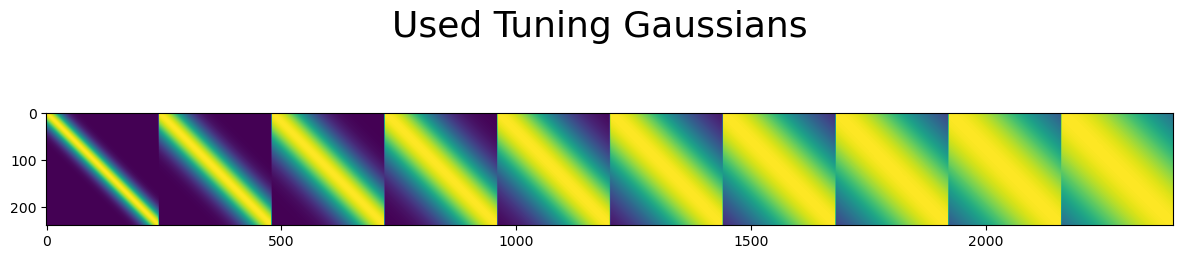

In [24]:
ax, fig = freqs_plot(pref_range, sharp_range)

### adaptation

In [25]:
def run_adaptation(stim_df, pref_range, sharp_range, y_decay):
    """wrapper functions to run adaptation model and return long matrixes of [pref*tw, stimuli]"""
    
    # calculate raw activation
    stims = stim_df['frequencies_oct'].to_numpy()
    activations = longtrace_adaptation.md_gaussian_activations(pref_range, sharp_range, stims)
    adaptations = np.zeros([len(pref_range)*len(sharp_range), len(stims)])
    n_back_adaptations = np.zeros([len(pref_range)*len(sharp_range), len(stims), len(y_decay)])

    for blk in stim_df['block'].unique():
        # get all stimuli within this block & get start and end idx of block
        stims = stim_df['frequencies_oct'][stim_df['block'] == blk].to_numpy()
        st_idx = stim_df.index[stim_df['block'] == blk][0]
        nd_idx = stim_df.index[stim_df['block'] == blk][-1] + 1

        # calculate adaptation for current block
        adaptations[:, st_idx:nd_idx], n_back_adaptations[:, st_idx:nd_idx, :] = longtrace_adaptation.md_stim_adaptation(stims, 
                                                                                                    y_decay, 
                                                                                                    pref_range, 
                                                                                                    sharp_range)

    # calculate adaptation weighted activations
    adapted_activations = np.multiply(adaptations, activations)

    return(activations, adaptations, adapted_activations, n_back_adaptations)


def adaptation_forwardmodel(stim_df, pref_range, sharp_range, adaptations, adapted_activations):
    """forward model the adaptation, given the stimulus presented get the experienced amount of adaptation, activation etc.
    input: stim_df: stimulus pandas dataframe with column ['frequencies_oct']
           pref_range: range of prefferences - must match adapations grid
           sharp_range: range of sharpnesses  - must match adapations grid
           adapations: adaptations grid
           adapted_activations: adapated activations grid
    returns:
           stim_df, with columns 'forward_adapation' and 'forward_adapted_activation'
           """

    # -- prepair grid
    # create a list of all indexes
    all_idxs = np.arange(len(pref_range) * len(sharp_range))

    # get grid of tuning pref and tuning sharpnesses
    tunprefs, tunsharps = longtrace_adaptation.md_get_tuning(all_idxs, pref_range, sharp_range)

    # -- tuning prefference grid possitioning
    # get minimum indx
    min_idx = np.argmin(np.abs(stim_df['frequencies_oct'].to_numpy()[:, np.newaxis] - pref_range), axis=1)

    # get discrete closest value back
    closest_val = pref_range[min_idx]

    # from discrete get boolean array
    pref_idx = closest_val == tunprefs[:, np.newaxis]

    # -- tuning width positioning
    # take one tw for now
    what_tw = sharp_range[5]

    # get bool array of where tw matches sellected tw
    tw_idx = np.tile(tunsharps == what_tw, (len(stim_df['frequencies_oct']), 1)).T

    # -- get logical intersection of the two
    # combine the two
    grid_idx = np.logical_and(pref_idx, tw_idx)
    grid_idx = np.argmax(grid_idx, axis=0)
    
    # save in dataframe
    stim_df['forward_adapation'] = adaptations[grid_idx, np.arange(len(grid_idx))]
    stim_df['forward_adapted_activation'] = adapted_activations[grid_idx, np.arange(len(grid_idx))]
    
    return(stim_df)

In [26]:
import adaptation.longtrace_adaptation as longtrace_adaptation
x_decay, y_decay = longtrace_adaptation.double_exp_decay_func(0.1399, 0.85, 0.0345, 6.82, [1, 10], 1)

activations, adaptations, adapted_activations, n_back_adaptations = run_adaptation(df_beh, 
                                                                                           pref_range, 
                                                                                           sharp_range, 
                                                                                           y_decay)
df_beh = adaptation_forwardmodel(df_beh, pref_range, sharp_range, adaptations, adapted_activations)

# cleanup collumns
del activations, adaptations, adapted_activations, n_back_adaptations

### pred - drex

In [27]:
#drex
def stims_export_mat(pp, input_dir, stim_df, pref_range):
    """export dataframe into mat file"""
    stim_mat = {}

    # get stimuli data
    stim_mat['stims'] = stim_df.to_dict('list')

    # aditionally get range data
    stim_mat['oct_range'] = list(pref_range)
    stim_mat['freq_range'] = list(2 ** pref_range)

    scipy.io.savemat(join(input_dir, '{}_stimdf.mat'.format(pp, pp)), stim_mat)
    return


def stims_add_drex(pp, input_dir, stim_df):
    """load drex output mat, and append to dataframe"""
    # load drex mat
    mat = scipy.io.loadmat(join(input_dir,'{}_drexdf.mat'.format(pp, pp)))

    # loop over frequencies
    collumn_names = ['pred_prob_{:.3f}'.format(frq) for frq in mat['s_range'][0]]
    temp_df = pd.DataFrame(columns=collumn_names)
    for frq in range(len(mat['s_range'][0])):
        cur_frq = mat['s_range'][0, frq]
        temp_df['pred_prob_{:.3f}'.format(cur_frq)] = mat['prob_array'][frq]

    # append surprisal and predictive probabilities
    stim_df['surprisal'] = mat['surp_array'][0]
    stim_df = pd.concat([stim_df, temp_df], axis=1)
    return(stim_df)

def stims_drex_forwardmodel(pp, input_dir, stim_df, drexfn_suffix='_drexdf.mat'):
    """forward model the adaptation, given the stimulus presented get the experienced amount of adaptation, activation etc.
    input: pp: participant number
           input_dir: what folder the drexdf.mat file is located
           stim_df: stimulus pandas dataframe with column ['frequencies_oct']
           drexfn_suffix(optional): suffix of the drexfilename
    returns:
           stim_df, with columns 'surprisal' and 'pred_prob'
           """
    # load drex mat
    mat = scipy.io.loadmat(join(input_dir,'{}{}'.format(pp, drexfn_suffix)))
    tunprefs = mat['s_range'][0]

    # get minimum indx
    min_idx = np.argmin(np.abs(stim_df['frequencies_oct'].to_numpy()[:, np.newaxis] - tunprefs), axis=1)

    # add surprisal and pred prob
    stim_df['surprisal']  = mat['surp_array'][0]
    stim_df['pred_prob']  = mat['prob_array'][min_idx, np.arange(len(min_idx))]

    return(stim_df)

In [28]:
# stims_export_mat(pp, data_dir, df_beh, pref_range)

# MATLAB FUNCTION : rundrex_stims(pp, input_dir)
# MATLAB WRAPPER FUNCTION : rundrex_bulk

df_beh = stims_drex_forwardmodel(pp, data_dir, df_beh)

In [29]:
def zscore_columns(df, columns):
    """
    Z-score the specified columns of a pandas df
    input:
        df: A pandas DataFrame.
        columns: A list of column names to be z-scored.
    returns: A DataFrame with the specified columns z-scored.
    """
    # zscore the sellected collumns
    df[columns] = (df[columns] - df[columns].mean()) / df[columns].std()
    return df

# zscore some collumns
df_beh = zscore_columns(df_beh, ['forward_adapation', 'forward_adapted_activation', 'surprisal', 'pred_prob'])

# on off putting in timing dataframe

## transformation into the time domain

In [30]:
## MOVE FUNCTIONS FROM STIMULUS DOMAIN INTO TIMEDOMAIN
## MAP 'STIMULUS' TO INDEX OF WHAT STIMULI, FOR EASY MAPPING

def stim_save_segments(df_beh, groupby_nm=['block', 'segment']):
    """apply a new column to behavioural dataframe with segment_all - 
    indicating a continious numerical indicator of what segment we are on"""

    # predefine segement all in df_beh
    df_beh['segment_all'] = np.nan
    
    # loop over block and segment combinations
    for idx, row in df_beh.groupby(groupby_nm).first().reset_index().iterrows():

        # save new segment all 
        df_beh.loc[(df_beh['block'] == row['block']) & (df_beh['segment'] == row['segment']), 'segment_all'] = idx 

    # return the dataframe
    return(df_beh)


def map_stim_to_time(df, df_beh, cn_stim='stimulus', cn_ts='TIMESTAMP', 
                     beh_cn_onset='timing_meg', beh_cn_offset='timing_offset_meg'):
    """transform / map stimulus dataframe into the time domain
    input: df: Pandas dataframe - time domain
           df_beh: Pandas dataframe - stim domain
           cn_stim: (optional) column name for stimulus indicator
           cn_ts: (optional) column name for timestamp indicater in time df
           beh_cn_onset: (optional) column name for onset time in beh_df
           beh_cn_offset: (optional) column name for offset time in beh_df"""
    
    # Apply the function to create the 'stimulus' column in df_time
    df['stimulus'] = df['TIMESTAMP'].apply(_assign_stimulus, 
                                           df_beh=df_beh,
                                           cn_onset=beh_cn_onset,
                                           cn_offset=beh_cn_offset,
                                           cn_stimulus=cn_stim)
    # Return the dataframe
    return(df)


def map_columns_to_time(df, df_beh, col_to_trans, indicator_nm='stimulus'):
    """map columns of interest to transfer to timedomain
    df: dataframe in timedomain
    df_beh: dataframe in stim domain
    col_to_trans: all columns to transfer
    indicator_nm: (optional) indicator name - what to use for the mapping"""
    
    # loop over columns to transfer
    for colnm in col_to_trans:

        # create a dictionary to map 'stimulus' to all conditions I want to transfer to the other df
        stimulus_to_col = df_beh.set_index(indicator_nm)[colnm].to_dict()

        # map function to go from one to another
        df[colnm] = df[indicator_nm].map(stimulus_to_col).fillna(0)
        
    # returns dataframe
    return(df)


def map_block_to_run(df, df_beh, run_nm='run', block_nm_beh='block', block_nm='BLOCK'):
    """map from blocknumber to run number in timedomain"""

    # create a dictionary to map 'block' to run
    map_block_run = df_beh.set_index(block_nm_beh)[run_nm].to_dict()

    # map the df
    df[run_nm] = df[block_nm].map(map_block_run).fillna(0).astype(int)

    # return dataframe
    return(df)


def time_save_segments(df, df_beh,
                       groupby_nm=['block', 'segment'],
                       onset_nm='timing_meg',
                       offset_nm='timing_offset_meg',
                       timing_mm='TIMESTAMP'
                      ):
    """save segments into the time domain dataframe
    df: timedomain dataframe
    df_beh: stimdomain dataframe
    groupby_nm: (optional) list of names to groupby
    onset_nm: (optional) what to use as onset timings - in same timeframe
    offset_nm: (optional) what to use as offset timings - in same timeframe
    timing_nm: (optional) time indicator in original dataframe"""

    # get dataframe of onset and offset timings only
    onset_df = df_beh.groupby(groupby_nm).first()[onset_nm].reset_index()
    offset_df = df_beh.groupby(groupby_nm).last()[offset_nm].reset_index()

    # predefine all new columns in our timedomain dataframe
    df['block'] = np.nan
    df['segment'] = np.nan
    df['segment_all'] = np.nan

    # loop over all index (combinations)
    for idx, row in onset_df.iterrows():

        # get start and endtime of groupby section
        cur_onset = onset_df[onset_nm].iloc[idx]
        cur_offset = offset_df[offset_nm].iloc[idx]

        # map to OG dataframe
        df.loc[(df[timing_mm] >= cur_onset) & (df[timing_mm] <= cur_offset), 'segment'] = onset_df['segment'].iloc[idx]

        # save per segment indicator
        df.loc[(df[timing_mm] >= cur_onset) & (df[timing_mm] <= cur_offset), 'segment_all'] = idx
    
    return(df)


def time_save_onoff(df, onoff_nm='onoff', indicator='stimulus'):
    """save onoff value (bool), based on indicator value"""

    # predefine
    df['onoff'] = 0
    # take wherever there is any stimulus - set to 1
    df.loc[(df['stimulus'] > 0), 'onoff'] = 1
    
    return(df)


# create a function to assign stimuli based on timing
def _assign_stimulus(timing, 
                     df_beh, 
                     cn_onset='timing_meg', 
                     cn_offset='timing_offset_meg',
                     cn_stimulus='stimulus'):
    """pandas apply function to get stimuli into the time domain
    input df_beh, cn_onset (optional columnname of onset time),
    cn_offset (optional columnname of offset time), cn_stimulus (optional columnname of stimulus)"""
    idx = np.searchsorted(df_beh[cn_onset], timing)
    if idx == 0 or timing >= df_beh[cn_offset].iloc[idx - 1]:
        return 0
    return df_beh[cn_stimulus].iloc[idx - 1]


In [31]:
## FUNCTION TO BIN VALUES OF SEVERAL THINGS TOGETHER

def create_binned_columns(df, column_name, num_levels):
    # Calculate the quantiles
    quantiles = df[column_name].quantile([i/num_levels for i in range(1, num_levels)])
    
    # Create binned columns within the loop
    for i in range(num_levels):
        if i == 0:
            # First bin
            df[f'{column_name}_L{i+1}'] = (df[column_name] <= quantiles.iloc[i]).astype(int)
        elif i < num_levels - 1:
            # Middle bins
            df[f'{column_name}_L{i+1}'] = ((df[column_name] > quantiles.iloc[i-1]) & (df[column_name] <= quantiles.iloc[i])).astype(int)
        else:
            # Last bin
            df[f'{column_name}_L{i+1}'] = (df[column_name] > quantiles.iloc[i-1]).astype(int)
    
    return df

df_beh = create_binned_columns(df_beh, 'surprisal', 3)
df_beh = create_binned_columns(df_beh, 'forward_adapation', 3)
df_beh = create_binned_columns(df_beh, 'forward_adapted_activation', 3)
df_beh = create_binned_columns(df_beh, 'pred_prob', 3)

In [32]:
# map stimulus indexing to timedomain (123 > 00011100222000333)
df = map_stim_to_time(df, df_beh, cn_stim='stimulus', cn_ts='TIMESTAMP', 
                     beh_cn_onset='timing_meg', beh_cn_offset='timing_offset_meg')

# get columns of interest to transfer and apply stim specific mapping
col_to_trans = ['frequencies', 'frequencies_oct', 'forward_adapation', 'forward_adapted_activation', 'surprisal', 'pred_prob',
                'surprisal_L1', 'surprisal_L2', 'surprisal_L3', 
                'forward_adapation_L1', 'forward_adapation_L2', 'forward_adapation_L3', 
                'forward_adapted_activation_L1', 'forward_adapted_activation_L2', 'forward_adapted_activation_L3',
                'pred_prob_L1', 'pred_prob_L2', 'pred_prob_L3']
# col_to_trans = ['frequencies', 'frequencies_oct', 'forward_adapation', 'forward_adapted_activation']

df = map_columns_to_time(df, df_beh, col_to_trans)

# save segment and segment all in timedomain and segment all in main stimulus domain dataframe
df = time_save_segments(df, df_beh)
df_beh = stim_save_segments(df_beh)

# use the blocknumber to runnumber pairing in stimulus domain to map block to run in time domain
df = map_block_to_run(df, df_beh)

# map segment specific data onto current segment
col_to_trans = ['center_freq_a', 'center_freq_b', 'center_freq_a_oct', 'center_freq_b_oct', 'probability_a', 'probability_b']
df = map_columns_to_time(df, df_beh, col_to_trans, indicator_nm='segment_all')

# save onoff inside timing dataframe
df = time_save_onoff(df)

In [33]:
## function to get inblock boolean
## TODO: MAKE IN SIMPLE FUNCTION

# Find start and end timings for each block
block_timings = df_beh.groupby('block')['timing_meg'].agg(['min', 'max'])

# predefine inblock bool
df['in_block'] = False

# loop over rows
for _, row in block_timings.iterrows():
    # Find the index of the closest TIMESTAMP value to the min and max timing
    min_idx = (df['TIMESTAMP'] - row['min']).abs().idxmin()
    max_idx = (df['TIMESTAMP'] - row['max']).abs().idxmin()
    
    # Set the in_block column to True for the range between min_idx and max_idx
    df.loc[min_idx:max_idx, 'in_block'] = True

## Get all data again but for only onset time - impulse

In [34]:
def time_transform_FIR(df, indicator, fir_columns,
                       prefix_fir = 'FIR_',
                       prefix_fir_offset = 'OFFSET_FIR_'):
    """within a dataframe, groupby indicator > loop over fir columns and make a boxplot a impulse (start + end)
    input: df: timedomain dataframe
           indicator: indicator for groupby (unqiue indicator that binds the fir_columns)
           fir_columns: the fir columns to loop over and add
           prefix_fir: (optional) prefix naming for new fir naming
           prefix_fir_offset: (optional) prefix naming for new fir ofset naming
    return: return adjusted dataframe
    """

    # create onset and ofset arrays for FIR modelling - per stimulus
    onset_idx  = df[df[indicator] > 0].groupby(indicator).apply(lambda x: x.index[0]).to_numpy()  # onset
    offset_idx = df[df[indicator] > 0].groupby(indicator).apply(lambda x: x.index[-1]).to_numpy() # offset

    # loop over columns of interest to re-insert into df as FIR
    for col in fir_columns:

        # predefine columns
        df[f'{prefix_fir}{col}'] = 0
        df[f'{prefix_fir_offset}{col}'] = 0

        # take first or last value from boxplot and make FIR
        df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
        df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
        
    return(df)

In [35]:
# get columns we want to take first instanse impulse for 
fir_columns  =  ['frequencies', 
                'frequencies_oct',
                'forward_adapation',
                'forward_adapted_activation',
                'surprisal',
                'pred_prob',
                'onoff']

fir_columns_binned  =  ['surprisal_L1', 'surprisal_L2', 'surprisal_L3', 
                        'forward_adapation_L1', 'forward_adapation_L2', 'forward_adapation_L3', 
                        'forward_adapted_activation_L1', 'forward_adapted_activation_L2', 'forward_adapted_activation_L3',
                        'pred_prob_L1', 'pred_prob_L2', 'pred_prob_L3']

# fir_columns  =  ['frequencies', 
#                 'frequencies_oct',
#                 'forward_adapation',
#                 'forward_adapted_activation',
#                 'onoff']

# add fir impulses to dataframe
df = time_transform_FIR(df, 'stimulus', fir_columns)
df = time_transform_FIR(df, 'stimulus', fir_columns_binned)
df = time_transform_FIR(df, 'BLOCK', ['BLOCK'])
df = time_transform_FIR(df, 'segment_all', ['segment_all'])

# try out FIR modelling

+ in principle we can simply timeshift these points in the window we want [-before_onset +after_onset]
+ for this we take 1/`ft_meeg_data['sfreq']` into account 
    + e.g 0.1/(60**-1) = 6 timesteps before onset
    + e.g.0.4/(60**-1) = 24 timesteps after onset
+ we can do this by simply .shift the dataframe, however, many of these toolboxes probably have this buildin
+ try this and plot the designmatrix
    + additionally plot the 0th time (onset time) horizontal line
    
    
also:
CHECK IF `EELBRAIN` WAS INSTALLED SUCCESFULLY, AND IF NOT TRY TO FIX

In [36]:
def add_event_from_df(raw, df, event_nm):
    """within the raw MNE object, using the matching nonzero indexes in df to add mne events
    input: raw: mne raw object - must include 'sfreq', here we add stim to
            df: dataframe with our stimulus (impulse/block) information
            event_nm: the name of the column in the dataframe which is the event
    output: returns raw mne object with object"""

    # calulate index position of events and the value of those events
    idxs      = np.where(df[event_nm] > 0)
    value     = df[event_nm].to_numpy()[idxs]

    # predefine numpy array in correct shape for mne
    mne_arr = np.zeros((len(idxs[0]), 3))
    mne_arr[:,0] = idxs[0]
    mne_arr[:,2] = value

    # # create new stimulus channel - ONOFF
    if event_nm not in raw.ch_names:
        temp_info = mne.create_info([event_nm], raw.info['sfreq'], ['stim'])
        stim_raw = mne.io.RawArray(df[[event_nm]].to_numpy().T, temp_info)
        raw.add_channels([stim_raw], force_update_info=True)

    # add actuall events
    raw.add_events(mne_arr, stim_channel=event_nm, replace=True)
    return(raw)

In [37]:
event_columns = ['FIR_frequencies', 
                'FIR_frequencies_oct',
                'FIR_forward_adapation',
                'FIR_forward_adapted_activation',
                'FIR_surprisal',
                'FIR_pred_prob',
                'FIR_onoff',
                'onoff']
# event_columns = ['FIR_frequencies', 
#                 'FIR_frequencies_oct',
#                 'FIR_forward_adapation',
#                 'FIR_forward_adapted_activation',
#                 'FIR_onoff',
#                 'onoff']

# add events for all 
for evnt in event_columns:
    raw = add_event_from_df(raw, df, evnt)

Creating RawArray with float64 data, n_channels=1, n_times=179914
    Range : 0 ... 179913 =      0.000 ...  2998.550 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179914
    Range : 0 ... 179913 =      0.000 ...  2998.550 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179914
    Range : 0 ... 179913 =      0.000 ...  2998.550 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179914
    Range : 0 ... 179913 =      0.000 ...  2998.550 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179914
    Range : 0 ... 179913 =      0.000 ...  2998.550 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179914
    Range : 0 ... 179913 =      0.000 ...  2998.550 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179914
    Range : 0 ... 179913 =      0.000 ...  2998.550 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=179914
    Range : 0 ... 179913

## creating FIR design matrix

In [38]:
from nilearn.glm.first_level import make_first_level_design_matrix

def designmat_create(df, coi, t_start, t_stop, 
                     clk_label='TIMESTAMP', onset_marker='FIR_onoff',
                     duration=1, drift_model='polynomial', return_eventdf=False):
    """create a designmatrix given the timedomain dataframe and t_start and t_stop
    for a function fully in the timedomain (interpolating the minus and plus ms start/stop) 
    use `designmat_create_td` instead - this version is timelocked to the nearest timepoint and 
    fully time resolution dependent
    input df: dataframe in timedomain containing timestamp and regressors
          coi: column/regressor of interest
          t_start: where to start for the fir regression (ussually minus)
          t_stop: where to stop the timeshift
          clk_label (optional): what timestamp value to use - also used to calculate timeresolution
          onset_marker (optional): what marker to be used to gather timedomain onset information
          duration (optional): standart 1 row - but can be longer if desired (will cause overlap)
          if return_eventdf : True, instead of designmatr return the event dictionary 
    return: returns X_mat - the design matrix"""
    
    # how manny timesteps do we require for our fir modeling - rounded down
    t_step = np.round(df['TIMESTAMP'].diff()[1], 5)  # calculate timestep
    n_times = int(np.round((t_stop - t_start) / t_step))

    # create arrays for current condition, for the durations of the fir (default one timestamp)
    onsets = df.loc[df[onset_marker] == 1, clk_label].apply(lambda x: (df[clk_label] - (x + t_start)).abs().idxmin())
    conditions = np.tile([coi], len(onsets))
    duration = np.tile(duration, len(onsets))
    modulation = df.loc[df[onset_marker] == 1, coi]

    # create event dictionary and corresponding dataframe
    event_dict = {
                "trial_type": conditions,
                "onset": onsets,
                "duration": duration,
                "modulation": modulation,
                 }
    event_df = pd.DataFrame(event_dict)

    # get tr, number of scans, and corresponding frame times
    frame_times = df.index.to_numpy()
    
    # early return - fix later for better code
    if return_eventdf: return(event_df) 
    
    # create the fir model
    hrf_model = "FIR"
    X_mat = make_first_level_design_matrix(
        frame_times,
        event_df,
        hrf_model="fir",
        drift_model=drift_model,
        drift_order=3,
        fir_delays=np.arange(0, n_times+1),
    )
    return(X_mat)


def designmat_create_td(df, coi, t_start, t_stop, 
                        clk_label='TIMESTAMP', onset_marker='FIR_onoff',
                        duration=None, drift_model='polynomial', return_eventdf=False):
    """create a designmatrix given the timedomain dataframe and t_start and t_stop fully timebased
    this function is timeresolution independent but will interpolate if not synced exactly
    input df: dataframe in timedomain containing timestamp and regressors
          coi: column/regressor of interest
          t_start: where to start for the fir regression (ussually minus)
          t_stop: where to stop the timeshift
          clk_label (optional): what timestamp value to use - also used to calculate timeresolution
          onset_marker (optional): what marker to be used to gather timedomain onset information
          duration (optional): standart the same as t_step, denoted in sec.
          if return_eventdf : True, instead of designmatr return the event dictionary 
    return: returns X_mat - the design matrix"""
    
    # how manny timesteps do we require for our fir modeling
    t_step = np.round(df['TIMESTAMP'].diff()[1], 4)  # calculate timestep
    n_times = int(np.round((t_stop - t_start) / t_step))
    if not duration: duration = t_step 
    
    # create arrays for current condition, for the durations of the fir (default one timestamp)
    onsets = df.loc[df[onset_marker] == 1, clk_label] + t_start
    onsets = onsets.round(4)
    conditions = np.tile([coi], len(onsets))
    duration = np.tile(duration, len(onsets))
    modulation = df.loc[df[onset_marker] == 1, coi]

    # get tr, number of scans, and corresponding frame times - round to make matching easier (1/10 ms)
    frame_times = df['TIMESTAMP'].round(4)

    # create event dictionary and corresponding dataframe
    event_dict = {
                "trial_type": conditions,
                "onset": onsets,
                "duration": duration,
                "modulation": modulation,
                 }
    event_df = pd.DataFrame(event_dict)
    
    # early return - fix later for better code
    if return_eventdf: return(event_df) 

    # create the fir model
    hrf_model = "FIR"
    X_mat = make_first_level_design_matrix(
        frame_times,
        event_df,
        hrf_model="fir",
        drift_model=drift_model,
        drift_order=3,
        fir_delays=np.arange(0, n_times+1),
    )
    return(X_mat)

In [39]:
# good settings for onoff - for modulation function we can go longer hopefully -0.1 to 0.4
t_start = -0.0333333       # = 3 timesteps  #TESTING FOR MISALIGNMENT
# t_start = 0.0
t_stop = 0.2166667
# t_stop = 0.2       # = 12 timesteps

# condtion of interest
cois = [#'FIR_frequencies_oct',
#         'FIR_forward_adapation',
        'FIR_onoff',
        'FIR_forward_adapted_activation',
        'FIR_surprisal',
        'FIR_pred_prob',
       ]
# cois = ['FIR_onoff']

clk_label = 'TIMESTAMP'

# predefine dataframe
design_mat = pd.DataFrame()

# for loop over cois
for coi in cois:
    
    # get design matrix for this condition
    event_df = designmat_create(df, coi, t_start, t_stop, clk_label='TIMESTAMP', duration=1, return_eventdf=True)
    design_mat = pd.concat([design_mat, event_df], axis=0)

# how manny timesteps do we require for our fir modeling - rounded down
t_step = np.round(df['TIMESTAMP'].diff()[1], 5)  # calculate timestep
n_times = int(np.round((t_stop - t_start) / t_step))
    
# get tr, number of scans, and corresponding frame times
frame_times = df.index.to_numpy()
    
# create the fir model
hrf_model = "FIR"
X_mat = make_first_level_design_matrix(
    frame_times,
    design_mat,
    hrf_model="fir",
    drift_model="polynomial",
    drift_order=3,
    fir_delays=np.arange(0, n_times+1),
)

# how we add non fir regressors easily
X_mat['in_block'] = df['in_block'].astype(float)
# X_mat['onoff'] = df['onoff']  # do we add this? as a onoff predictor? general sound response

# Now, remove the constant term from the design matrix # DO WE REMOVE THIS?
# if 'constant' in X_mat.columns:
#     X_mat = X_mat.drop('constant', axis=1)

# filter only onoff sets
X_mat['on'] = X_mat.filter(like='FIR_onoff_delay_').sum(axis=1) > 0
X_mat['on'] = X_mat['on'].astype(float)

A 'modulation' column was found in the given events data and is used.


In [40]:
# Find events
events = mne.find_events(raw, stim_channel='FIR_onoff')

# Create epochs
epochs = mne.Epochs(raw, events, tmin=t_start, tmax=t_stop, preload=True, baseline=(0, 0))


# Get the number of channels and the number of time points
n_channels = len(epochs.info['ch_names'])
n_times = len(epochs.times)

# Create a numpy array of zeros with the shape (n_channels, n_times)
data = np.zeros((n_channels, n_times))

# Create the dummy EvokedArray
ev_dummy = mne.EvokedArray(data, epochs.info, tmin=epochs.tmin)

# Get the timestamps
timestamps = ev_dummy.times

11520 events found
Event IDs: [1]
Not setting metadata
11520 matching events found
Removing 1280 compensators from info because not all compensation channels were picked.
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11520 events and 16 original time points ...
0 bad epochs dropped


<AxesSubplot:label='conditions', ylabel='scan number'>

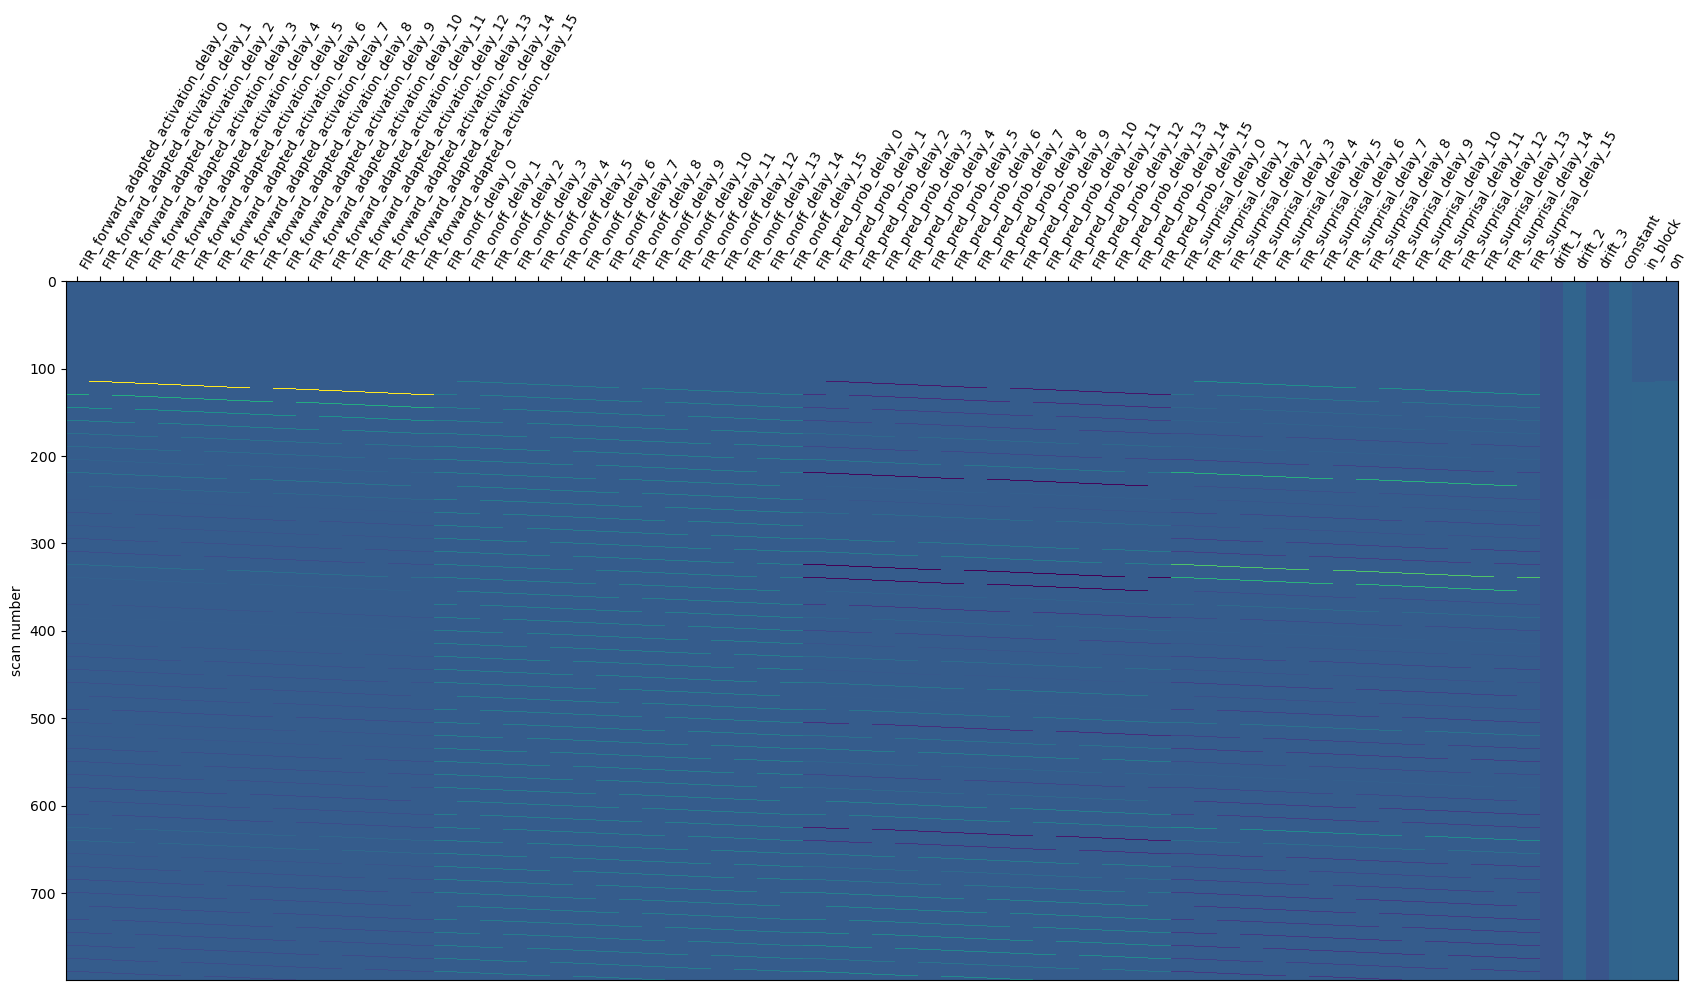

In [41]:
%matplotlib inline

from nilearn.plotting import plot_design_matrix
plot_design_matrix(X_mat.head(800))

In [42]:
## CALCULATE MATRIX RANK

# Calculate the rank of the matrix
rank = np.linalg.matrix_rank(X_mat)

# Print the rank
print(f"Rank of matrix \n -Rank: \t\t {rank} \n -Shape of matrix: \t {X_mat.shape} \n -Rank deficientcy: \t {rank < min(X_mat.shape)}")


Rank of matrix 
 -Rank: 		 70 
 -Shape of matrix: 	 (179914, 70) 
 -Rank deficientcy: 	 False


### bin data together

uncomment and put in function later

### Ridge toybox
playing around with ridge, doing estimations 
- ridge L2 norm estimation using RidgeCV 
- custom penalty matrix for ridge

In [43]:
## CHECK OPTIMAL L2 NORM FOR RIDGE USING RIDGECV

from sklearn.linear_model import RidgeCV

def ridge_calc_optimal_alpha(log_st, log_nd, nr_per_log=1):
    """calculate the optimal ridge alpha using a cross validation approach
    input: log_st: starting point in logspace - lowest lambda (e.g. -2 equals 1e-2)
           log_nd: end point in logspace - highest lambda
           nr_per_log: number of intermediate points wanted in logspace, default 1
                       value of one has no intermediate values - higher number more alpha values
                       but slower
    output: returns optimal alpha value"""

    # list of alphas to try
    alpha_values = np.logspace(log_st, log_nd, num=((log_nd - log_st)*nr_per_log)+1)

    # create RidgeCV instance with specific alphas
    ridge = RidgeCV(alphas=alpha_values, store_cv_values=True)

    # Fit the model
    ridge.fit(X_mat, y)

    # optimal alpha
    optimal_alpha = ridge.alpha_
    print(f"optimal alpha is {optimal_alpha}")
    return(optimal_alpha)

# do the actual optimization
# ridge_calc_optimal_alpha(-4, 4, nr_per_log=2)

## do the actual regressions

In [44]:
# select and oder data based on channel names - convert to numpy
raw_data = df[ ft_meeg_data['ch_names'] ].to_numpy().T


In [45]:
def z_score_blocks(df, ch_names, blk_nm='BLOCK'):
    """zscore per block and return adjusted dataframe
    input dataframe: with channels and block identifier
    ch_names: name of channels to zscore (i.e. data channels)
    blk_nm: name of catagory to zscore over
    returns adjusted dataframe"""

    # make a copy of our original dataframe
    df_zs = df.copy(deep=True)

    # loop over blocks
    for blk in df_zs[blk_nm].unique():

        # z-score current block and save in correct location
        df_zs.loc[df_zs[blk_nm] == blk, ch_names] = z_score(df_zs.loc[df_zs[blk_nm] == blk, ch_names])
    return df_zs
    

def z_score(df):
    """zscore multiple columns at once"""
    return ((df - df.mean())/df.std(ddof=0))


In [46]:
## TESTING WITH SKLEARN

from sklearn.linear_model import LinearRegression, Ridge, Lasso

def simplified_multioutput_regression_ridge(X_mat, data, solver='sparse_cg', alpha=1.0, fit_intercept=True):

    # Initialize the linear regression model
    model = Ridge(alpha=alpha, solver=solver, fit_intercept=fit_intercept, max_iter=1000, tol=0.001)
    
    # Fit the model
    model.fit(X_mat, data)

    # Predict to compute R-squared for each channel
    y_pred = model.predict(X_mat)
    rsquared = 1 - ((data - y_pred) ** 2).sum(axis=0) / ((data - data.mean(axis=0)) ** 2).sum(axis=0)

    # Compute correlation coefficient for each channel
    correlations = [np.corrcoef(data[:, i], y_pred[:, i])[0, 1] for i in range(data.shape[1])]

    results = {
        "coefficients": model.coef_,
        "intercepts": model.intercept_,
        "rsquared": rsquared,
        "correlations": correlations
    }
    
    return results


def simplified_multioutput_regression_ols(X_mat, data, fit_intercept=True):

    # Initialize the linear regression model
    model = LinearRegression(fit_intercept = fit_intercept)
    
    # Fit the model
    model.fit(X_mat, data)

    # Predict to compute R-squared for each channel
    y_pred = model.predict(X_mat)
    rsquared = 1 - ((data - y_pred) ** 2).sum(axis=0) / ((data - data.mean(axis=0)) ** 2).sum(axis=0)

    # Compute correlation coefficient for each channel
    correlations = [np.corrcoef(data[:, i], y_pred[:, i])[0, 1] for i in range(data.shape[1])]

    results = {
        "coefficients": model.coef_,
        "intercepts": model.intercept_,
        "rsquared": rsquared,
        "correlations": correlations
    }
    
    return results


In [47]:
## cleanup something to make plots easier readable

def align_polarity(coef_vals):
    """Align the polarity of the coefficients based on the sign of the maximum absolute value coefficient."""
    return np.array([coef * (1 if max(coef, key=abs) >= 0 else -1) for coef in coef_vals])

import numpy as np

def simple_moving_average(data, window_size):
    """
    Computes the simple moving average of the given data.
    
    Parameters:
    - data: The time series data.
    - window_size: The size of the moving average window.
    
    Returns:
    - A list containing the smoothed data.
    """
    if window_size <= 1:
        return data
    
    smoothed_data = []
    for i in range(len(data)):
        start_idx = max(0, i - window_size + 1)
        end_idx = i + 1
        smoothed_data.append(np.mean(data[start_idx:end_idx]))
        
    return smoothed_data


def demean_simple(data, timestamps, boundary=None):
    """demean the data based on where timestamps threshold is before onset"""
    
    # Set default boundary if not provided
    if boundary is None:
        boundary = [-np.inf, 0.0001]

    # get indexes of 'baseline'
    before_onset = np.where((timestamps >= boundary[0]) & 
                            (timestamps < boundary[1]))[0]

    # get means and demean data
    mz = np.mean(data[:, before_onset], axis=1)
    data = data - mz[:, None]
    
    return data

In [48]:
import numpy as np

def simple_moving_average_2d(data, window_size):
    """
    Computes the simple moving average of the given 2D data.
    
    Parameters:
    - data: The 2D time series data where the first dimension is the number of sensors, 
      and the second dimension is the time data.
    - window_size: The size of the moving average window.
    
    Returns:
    - A 2D list containing the smoothed data for each sensor.
    """
    num_sensors, num_samples = data.shape
    if window_size <= 1:
        return data
    
    smoothed_data = np.zeros((num_sensors, num_samples))
    
    for sensor_idx in range(num_sensors):
        for time_idx in range(num_samples):
            start_idx = max(0, time_idx - window_size + 1)
            end_idx = time_idx + 1
            smoothed_data[sensor_idx, time_idx] = np.mean(data[sensor_idx, start_idx:end_idx])
        
    return smoothed_data


In [49]:
X_mat_copy = X_mat.copy(deep=True)
# X_mat = X_mat_copy.copy(deep=True)
# X_mat = X_mat.drop(columns=['in_block', 'onoff', 'constant', 'drift_1', 'drift_2', 'drift_3'])
X_mat = X_mat.drop(columns=['in_block', 'constant'])

11520 events found
Event IDs: [1]
Not setting metadata
11520 matching events found
Removing 1280 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11520 events and 16 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


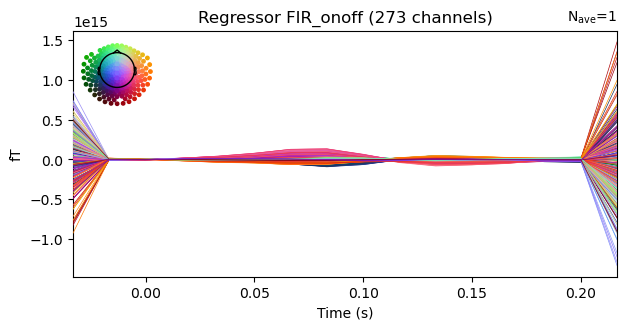

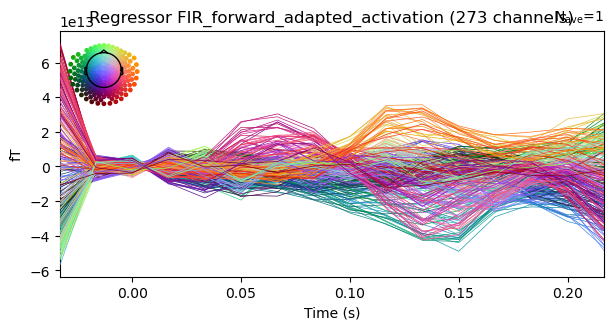

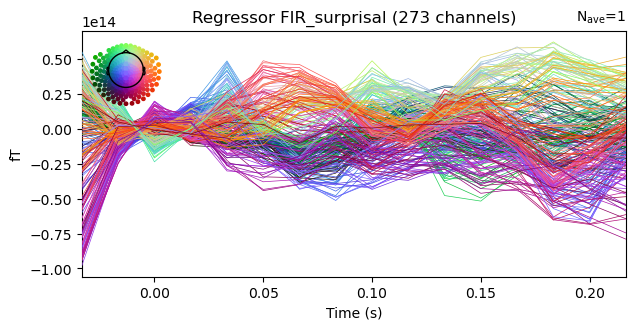

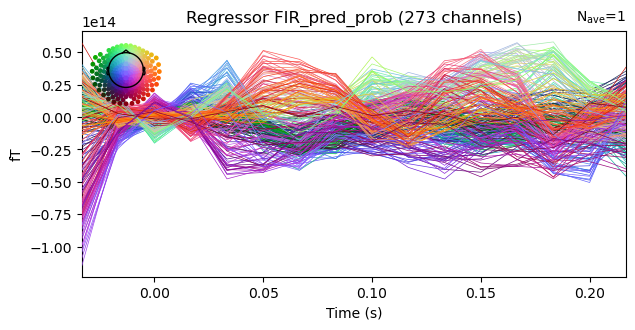

In [50]:
import numpy as np
import mne

import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt


## DO THE REGRESSION

# channel names (in input of function)
df_zs = z_score_blocks(df, ft_meeg_data['ch_names'])

# select and oder data based on channel names - convert to numpy
y = df_zs[ ft_meeg_data['ch_names'] ].to_numpy()




## OPTION A. USING OLS

# run the regression
results = simplified_multioutput_regression_ols(X_mat, y, fit_intercept=False)
results['coefficients'].shape



# OPTION B. USING PENALIZED RIDGE

# calculate optimal alpha
# optimal_alpha = ridge_calc_optimal_alpha(-4, 4, nr_per_log=2)
# optimal_alpha = 1

# alternatively quatratically penalized ridge
# M = create_penalty_matrix(n_features, intercept=True)
# results = ridge_quadpenalize(X_mat.to_numpy(), y, M, optimal_alpha, intercept=True)




## PLOT THE REGRESSION



# Extract base names of the regressors
base_names = cois
# base_names = ['FIR_frequencies_oct', 'FIR_onoff', 'FIR_pred_prob', 'FIR_surprisal']

# Find events / create epochs
events = mne.find_events(raw, stim_channel='FIR_onoff')
epochs = mne.Epochs(raw, events, tmin=t_start, tmax=t_stop, preload=True, baseline=None)


## PUTT ALL COEFFICIENTS RESULTS INTO ONE DATAFRAME ##

# Convert coefficients to DataFrame
df_coefs = pd.DataFrame(results['coefficients'], columns=X_mat.columns)

# Use list comprehension to get 2D arrays for each base and stack them to get a 3D array
final_coefficients = np.stack([
    df_coefs.filter(like=f"{base}_delay_").to_numpy() for base in base_names
    ])


## PUT INTO EVOLKED DATADRAME

# Get the times array from epochs
times = np.linspace(epochs.tmin, epochs.tmax, final_coefficients.shape[2])

# select only sensor data
epochs.pick_types(meg=True, stim=False)

# Convert the numpy array to an Evoked object for each regressor
evokeds = []
datas = {}
for i in range(final_coefficients.shape[0]):
    # Average across epochs (axis 2) for each regressor
    data = final_coefficients[i]
    
    # somewhat clean up the data a bit
    if i == 0: # for first itteration take evoked timestamps (from dummy evoked)
        ev_dummy = mne.EvokedArray(data, epochs.info, tmin=epochs.tmin)
        timestamps = ev_dummy.times
        del ev_dummy
        
    # demean values for cleaner plotting
#     data = demean_simple(data, timestamps, boundary=[-0.02, 0.02])
#     data = simple_moving_average_2d(data, 2)
#     data = align_polarity(data)
    
    datas[i] = data
    
    # append evoked results
    evoked = mne.EvokedArray(data, epochs.info, tmin=epochs.tmin, baseline=(-0.02, 0.02))
    evoked.comment = f'{base_names[i-1]}'
#     evoked = mne.EvokedArray(data, epochs.info, tmin=epochs.tmin)
    
#     # do axial to planar transformation
#     evoked = evoked.as_type('mag')
    
    # save in dict
    evokeds.append(evoked)

# Now you can plot the evoked objects for each regressor
for idx, evoked in enumerate(evokeds, 1):
    evoked.plot(titles=f'Regressor {base_names[idx-1]}')


## vergelijken

In [51]:
## QUADRATICALLY PENALIZED RIDGE

from numpy.linalg import inv

def ridge_quadpenalize(X, y, M, lambd, intercept=True):
    """run a costum ridge regression that quadratically penalize
    based on a costum penalization matrix
    w = X.T * inv(X X.T + lambd M) y
    input X: design matrix (np_array)
          y: results matrix - nr_outputs * datapoints (np_array)
          M: costum penalization matrix
          lambd: ridge parameter
          intercept: default True
    return: results dict, with coefficients, intercepts, rsquared, correlations """
    
    # do appropriate ridge based on intercept setting
    if intercept:
        w = _custom_ridge_regression_intercept(X, y, M, lambd)
        intercept, coefficients = w[0], w[1:]

        # Make predictions
        X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
        y_pred = X_with_intercept @ w
        
    else:
        w = _custom_ridge_regression(X, y, M, lambd)
        intercept, coefficients = None, w
        
        # Make predictions
        y_pred = X_mat.to_numpy() @ w
        
    # Gather stats
    rsquared = 1 - ((y - y_pred) ** 2).sum(axis=0) / ((y - y.mean(axis=0)) ** 2).sum(axis=0)
    correlations = [np.corrcoef(y[:, i], y_pred[:, i])[0, 1] for i in range(y.shape[1])]
        
    # Save into dictionary
    results = {
        "coefficients": coefficients.T,
        "intercepts": intercept,
        "rsquared": rsquared,
        "correlations": correlations
        }
    return(results)
        

def create_penalty_matrix(n_features, intercept=True):
    """create a quadratically penalize M matrix, 
    to be using in complex ridge were we penalize 
    the difference between each two neighboring terms of w
    """
    if intercept: n_features += 1
    M = np.diag(2 * np.ones(n_features))
    for i in range(n_features -1):
        M[i, i + 1] = -1
        M[i + 1, i] = -1
    M[0, 0] = 1
    M[n_features -1, n_features -1] = 1
    return M

def _custom_ridge_regression(X, y, M, lambd):
    """custom ridge regression, model without intercept (ok for z-scored)"""
    n_features = X.shape[1]
    # compute ridge reg solution
    w = inv(X.T @ X + lambd * M) @ X.T @ y
    return w

def _custom_ridge_regression_intercept(X, y, M, lambd):
    """custom ridge regression, model with intercept"""
    n_samples, n_features = X.shape
    # Add a column of ones to X for the intercept
    X_with_intercept = np.hstack([np.ones((n_samples, 1)), X])
    n_features += 1  # Adjust for added intercept column
    # Compute the ridge regression solution
    w = inv(X_with_intercept.T @ X_with_intercept + lambd * M) @ X_with_intercept.T @ y
    return w

## option 2: MNE regression rERF function

11520 events found
Event IDs: [1]
Not setting metadata
11520 matching events found
Removing 1280 compensators from info because not all compensation channels were picked.
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11520 events and 16 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (4496 targets, 4 regressors)


/scratch/jorvhar/50715505.dccn-l029.dccn.nl/ipykernel_6353/2990587001.py:20: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, reg_oi, names=reg_names)


Done


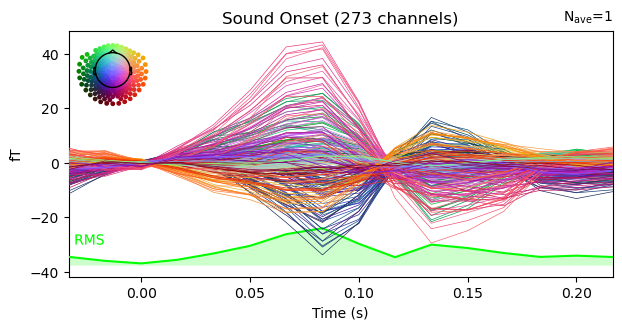

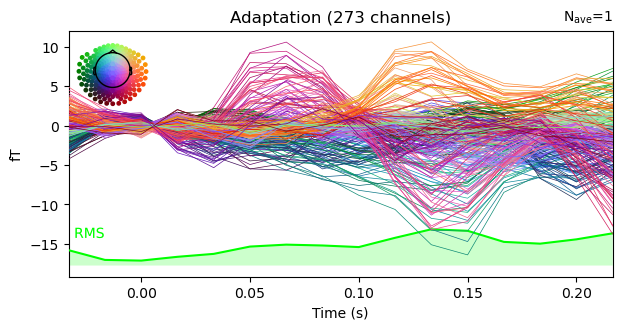

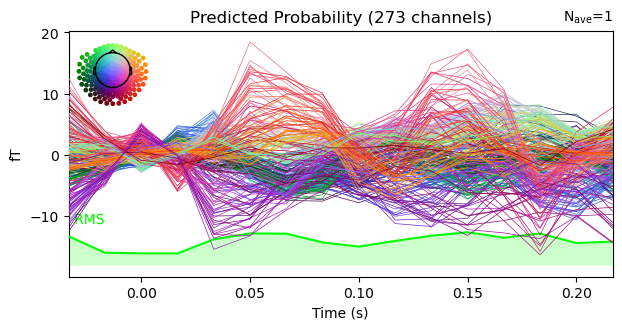

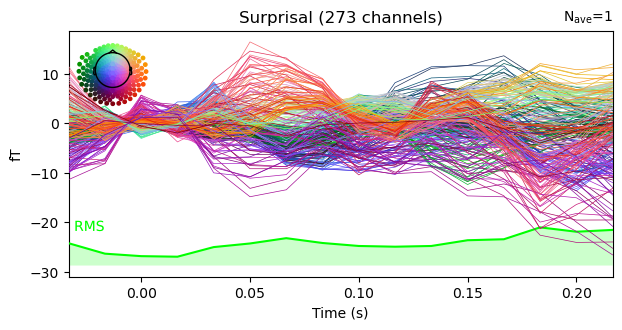

In [52]:
# ## CLASSICAL APPROACH OF MNE REGRESSIONS FOR ADAPTATION PRED SURPRISAL

import mne
from mne.stats import linear_regression

# Find events
events = mne.find_events(raw, stim_channel='FIR_onoff')

# Create epochs
epochs = mne.Epochs(raw, events, tmin=t_start, tmax=t_stop, preload=True, baseline=(-0.02,0.02))

# Get the data for the 'fir_surprisal' channel
fir_surprisal_data = raw.copy().pick_channels(['FIR_onoff']).get_data()

# Perform linear regression
df_beh['FIR_onoff'] = 1
reg_names = ['FIR_onoff','forward_adapted_activation','surprisal','pred_prob']
reg_oi = df_beh[reg_names].to_numpy()
# reg_oi = fir_surprisal_data[fir_surprisal_data > 0, np.newaxis]
res = linear_regression(epochs, reg_oi, names=reg_names)

# Access the beta values and related information
beta_values = res['surprisal'].beta#.as_type("grad")
t_values = res['surprisal'].t_val#.as_type("grad")
p_values = res['surprisal'].p_val#.as_type("grad")

# Access and plot the beta values directly
res['FIR_onoff'].beta.plot(gfp=True, titles='Sound Onset')
res['forward_adapted_activation'].beta.plot(gfp=True, titles='Adaptation')
res['pred_prob'].beta.plot(gfp=True, titles='Predicted Probability')
res['surprisal'].beta.plot(gfp=True, titles='Surprisal');

In [53]:
# sdve data
import pickle

# initiate list
resz = []

# loop over conditions and stats
for r in res:
    for st in res[r]._asdict():
        
        # add condition parameter from key
        res[r]._asdict()[st].comment = f'{st}_{r}'
        
        # append to list
        resz.append(res[r]._asdict()[st])
        
# save evokeds
# mne.write_evokeds(f'{input_dir}MNE_regression-sub-{pp:03}-ave.fif', resz, overwrite=True)
input_dir = f'/project/3018063.01/preproc/sub-{pp:03}/evoked/'
mne_res = {r.comment: r.get_data() for r in resz} # place mne results into dict

with open(f'{input_dir}MNE_regression-sub-{pp:03}.pickle', 'wb') as handle:
    pickle.dump(mne_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

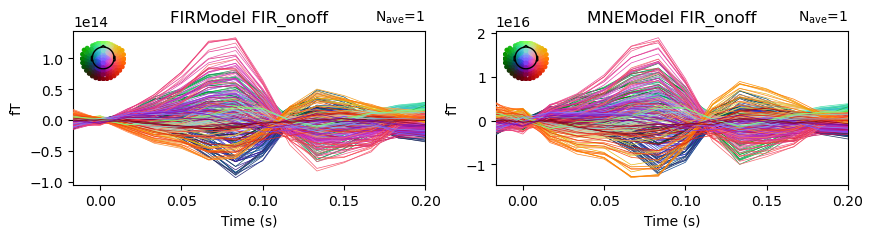

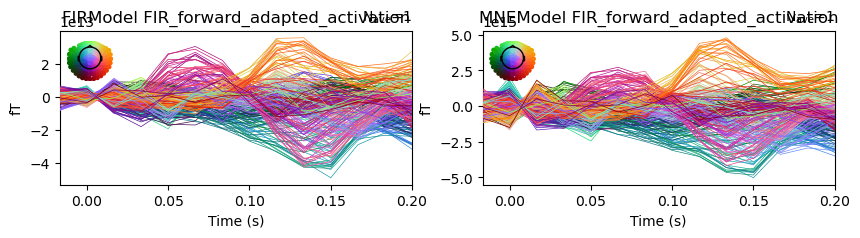

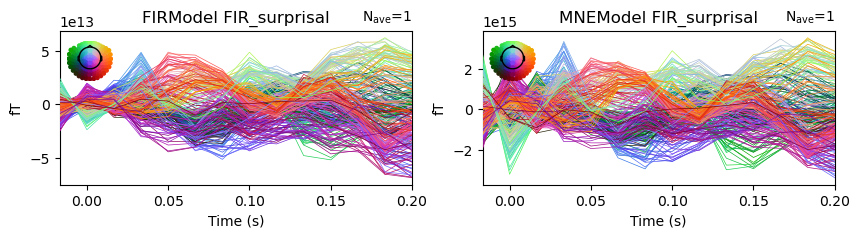

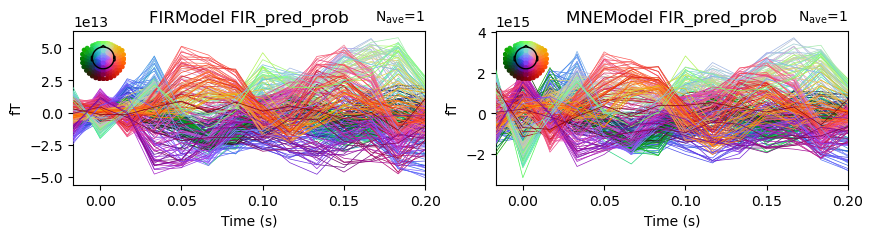

In [54]:
mnemodel = ['FIR_onoff', 'forward_adapted_activation', 'surprisal', 'pred_prob']

# # Create a figure with two subplots
# fig, ax = plt.subplots(len(mnemodel), 2, figsize=(14, 8))  # Adjust the figure size as needed

params = dict(
    spatial_colors=True, show=False, ylim=dict(grad=(-200, 200)), time_unit="s"
)

for idx in range(len(evokeds)):
    
    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(10, 2))  # Adjust the figure size as needed
    
    # Slice the Evoked data
    evoked_sliced = evokeds[idx].copy().crop(tmin=-0.01666667, tmax=0.2)
    # Plot the sliced data
    evoked_sliced.plot(axes=ax[0],  **params)
    
    # Slice the Evoked data
    evoked_sliced = res[mnemodel[idx]].t_val.copy().crop(tmin=-0.01666667, tmax=0.2)
    # Plot the sliced data
    evoked_sliced.plot(axes=ax[1], titles=f'Regressor {base_names[idx]}',  **params)
    
    ax[0].set_title(f'FIRModel {base_names[idx]}')
    ax[1].set_title(f'MNEModel {base_names[idx]}')

    
# plt.tight_layout()  # Adjust the layout
# plt.show()

## planar transf. in matlab

In [55]:
# settings
task = 0     # 0: main, 1: localizer
loc_run = 1  # run 1 or run 2

# MEG directory and file names
tasks = ['main', 'loc']
input_dir = f'/project/3018063.01/preproc/sub-{pp:03}/evoked/'
prefix = 'MNE_'
# OPTION A. use mne reg
ev_nm = ['FIR_onoff', 'forward_adapted_activation', 'pred_prob', 'surprisal']
evs = [res[nm].t_val for nm in ev_nm]
# loop over and assign comments
for i in range(len(ev_nm)):
    evs[i].comment = ev_nm[i]
    
# OPTION B. use own reg
# evs = evokeds

# if directory doesnt exists create it
if not os.path.isdir(input_dir):
    os.mkdir(input_dir)
    
# loop over evoked and prepair for exporting to matlab
for ev in evs:
    
    # remove suffix
    ev.info._unlocked = True   # unlock to prevent safety checks and be able to change info as desired
    ev.info['ch_names'] = [ch_name.replace('-4304', '') if '-4304' in 
                               ch_name else ch_name for ch_name in ev.info['ch_names']]
    ev.info['chs'] = [{**ch, 'ch_name': ch['ch_name'].replace('-4304', '')} if '-4304' in 
                          ch['ch_name'] else ch for ch in ev.info['chs']]

    # Also, update the montage if it exists
    if ev.info['dig'] is not None:
        for d in ev.info['dig']:
            if 'ch_name' in d and '-4304' in d['ch_name']:
                d['ch_name'] = d['ch_name'].replace('-4304', '')
    
    ev.save(f'{input_dir}{prefix}{ev.comment}-sub-{pp:03}.fif', overwrite=True)

Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping


/scratch/jorvhar/50715505.dccn-l029.dccn.nl/ipykernel_6353/4142189181.py:39: RuntimeWarning: This filename (/project/3018063.01/preproc/sub-001/evoked/MNE_FIR_onoff-sub-001.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  ev.save(f'{input_dir}{prefix}{ev.comment}-sub-{pp:03}.fif', overwrite=True)
/scratch/jorvhar/50715505.dccn-l029.dccn.nl/ipykernel_6353/4142189181.py:39: RuntimeWarning: This filename (/project/3018063.01/preproc/sub-001/evoked/MNE_forward_adapted_activation-sub-001.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  ev.save(f'{input_dir}{prefix}{ev.comment}-sub-{pp:03}.fif', overwrite=True)
/scratch/jorvhar/50715505.dccn-l029.dccn.nl/ipykernel_6353/4142189181.py:39: RuntimeWarning: This filename (/project/3018063.01/preproc/sub-001/evoked/MNE_pred_prob-sub-001.fif) does not conform to MNE naming conventions. A

In [56]:
# OPTION B. use own reg
prefix = ''
evs = evokeds

# if directory doesnt exists create it
if not os.path.isdir(input_dir):
    os.mkdir(input_dir)
    
# loop over evoked and prepair for exporting to matlab
for ev in evs:
    
    # remove suffix
    ev.info._unlocked = True   # unlock to prevent safety checks and be able to change info as desired
    ev.info['ch_names'] = [ch_name.replace('-4304', '') if '-4304' in 
                               ch_name else ch_name for ch_name in ev.info['ch_names']]
    ev.info['chs'] = [{**ch, 'ch_name': ch['ch_name'].replace('-4304', '')} if '-4304' in 
                          ch['ch_name'] else ch for ch in ev.info['chs']]

    # Also, update the montage if it exists
    if ev.info['dig'] is not None:
        for d in ev.info['dig']:
            if 'ch_name' in d and '-4304' in d['ch_name']:
                d['ch_name'] = d['ch_name'].replace('-4304', '')
    
    ev.save(f'{input_dir}{prefix}{ev.comment}-sub-{pp:03}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


/scratch/jorvhar/50715505.dccn-l029.dccn.nl/ipykernel_6353/1395470613.py:25: RuntimeWarning: This filename (/project/3018063.01/preproc/sub-001/evoked/FIR_pred_prob-sub-001.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  ev.save(f'{input_dir}{prefix}{ev.comment}-sub-{pp:03}.fif', overwrite=True)
/scratch/jorvhar/50715505.dccn-l029.dccn.nl/ipykernel_6353/1395470613.py:25: RuntimeWarning: This filename (/project/3018063.01/preproc/sub-001/evoked/FIR_onoff-sub-001.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  ev.save(f'{input_dir}{prefix}{ev.comment}-sub-{pp:03}.fif', overwrite=True)
/scratch/jorvhar/50715505.dccn-l029.dccn.nl/ipykernel_6353/1395470613.py:25: RuntimeWarning: This filename (/project/3018063.01/preproc/sub-001/evoked/FIR_forward_adapted_activation-sub-001.fif) does not conform to MNE naming conventions. All e

## cross validation

In [57]:
def train_test_block(df, n_splits, shuffle=True, random_state=123, group='BLOCK'):
    """ Main function for splitting df by groups, returns two arrays of training / testing set
    for cross validation
    input: dataframe, number op splits, shuffle default is set to true, default seed=123
           group = (default='Text_Nr'), choose variable to split on, 'Text_Nr' or 'Trial'
    return: matrix of (splits, texts_in_set) for train and test
    """
    # get list of text from dataframe, and set kfold
    texts = df.groupby(group).first().index.to_numpy()
    kf = KFold(n_splits=n_splits, 
               shuffle=True, 
               random_state=123)
    
    # save empty list for train and test texts
    train_indexes = np.empty((0, int(len(texts)-len(texts)/n_splits)), int)
    test_indexes = np.empty((0, int(len(texts)/n_splits)), int)
    
    # loop for text in folds
    for train_index, test_index in kf.split(texts):
        train_indexes = np.append(train_indexes, 
                                  np.array([texts[train_index]]), 
                                  axis=0)
        test_indexes = np.append(test_indexes,
                                 np.array([texts[test_index]]),
                                 axis=0)
    
    # return train and test indexes
    return(train_indexes, test_indexes)

In [58]:
## TESTING WITH SKLEARN

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from scipy import stats, linalg

# lambdas
zs=lambda x: (x-x.mean(0)) /x.std(0)
corr_column= lambda a,b: (zs(a)*zs(b)).mean(0)

def cross_regression_scoring(model, X_train,X_test,y_train,y_test, X_mat, base_names, save_predict=False):
    """take a linear model, the train/test data and do scoring
    input:  model:    input sklearn model;
            X_train:  regressor input train data
            X_test:   regressor input test data
            y_train:  target train data
            y_test:   target test data
            X_mat:    original design matrix - pandas dataframe, used for epoch parsing
            base_names:  base name of predictors
            save_predict:   save individual trail-by-trail predictions
    output: return rawscores dictionary (unorganised in timewindow) & scores dictionary (organised in time window)"""
    
    # Fit the model
    model.fit(X_train, y_train)

    # Predict to compute R-squared for each channel
    y_pred = model.predict(X_test)
    rsquared = 1 - ((y_test - y_pred) ** 2).sum(axis=0) / ((y_test - y_test.mean(axis=0)) ** 2).sum(axis=0)

    # Compute correlation coefficient for each channel
    correlations = corr_column(y_test, y_pred)

    rawscores = {
        "coefficients": model.coef_,
        "intercepts": model.intercept_,
        "rsquared": rsquared,
        "correlations": correlations
    }
    
    # save prediction scores if flagged
    if save_predict:
        rawscores['predict'] = {'y_pred': y_pred, 'y': y_test}
    
    # calculate t statisics and save in dict
    beta, stderr, t_val, p_val, mlog10_p_val = _calc_t_stats(X_mat, X_train, y_test, y_pred, model.coef_, base_names)
    scores = {"beta": beta,
              "stderr": stderr,
              "t_val": t_val,
              "p_val": p_val,
              "mlog10_p_val": mlog10_p_val}
    return rawscores, scores


def no_cv_regression_scoring(model, X, y, X_mat, base_names, save_predict=False):
    """take a linear model, the train/test data and do scoring
    input:  model:    input sklearn model;
            X:  regressor
            y:  target
            X_mat:    original design matrix - pandas dataframe, used for epoch parsing
            base_names:  base name of predictors
            save_predict:   save individual trail-by-trail predictions
    output: return rawscores dictionary (unorganised in timewindow) & scores dictionary (organised in time window)"""
    
    # Fit the model
    model.fit(X, y)

    # Predict to compute R-squared for each channel
    y_pred = model.predict(X)
    rsquared = 1 - ((y - y_pred) ** 2).sum(axis=0) / ((y - y.mean(axis=0)) ** 2).sum(axis=0)

    # Compute correlation coefficient for each channel
    correlations = corr_column(y, y_pred)

    rawscores = {
        "coefficients": model.coef_,
        "intercepts": model.intercept_,
        "rsquared": rsquared,
        "correlations": correlations
    }
    
    # save prediction scores if flagged
    if save_predict:
        rawscores['predict'] = {'y_pred': y_pred, 'y': y}
    
    # calculate t statisics and save in dict
    beta, stderr, t_val, p_val, mlog10_p_val = _calc_t_stats(X_mat, X, y, y_pred, model.coef_, base_names)
    scores = {"beta": beta,
              "stderr": stderr,
              "t_val": t_val,
              "p_val": p_val,
              "mlog10_p_val": mlog10_p_val}
    return rawscores, scores


def _calc_t_stats(X_mat, X_train, y_test, y_pred, betas, base_names):
    """ helper function to calulate t-statistics of regression fit
    input:
        X_mat: pandas dataframe with design - using column names for subgrouping
        X_train: training split (numpy array) of predictors
        y_test: y testing split - can be multioutput
        y_pred: y testing predictions 
        betas: array of betas
        base_names:  base name of predictors
    returns:
        beta, stderr, t_val, p_val, mlog10_p_val
    """

    # get number of rows and predictors in train
    n_rows, n_predictors = X_train.shape

    # assign Betas to df
    betas_df = pd.DataFrame(betas, columns=X_mat.columns)
    # calculate the Residual Sum of Squares (RSS)
    rss = np.sum((y_test - y_pred) ** 2, axis=0)

    # calculate degrees of freedom
    d_f = n_rows - n_predictors

    # calculate the quare root of the noise variance
    sqrt_noise_var = np.sqrt(rss/d_f)
    # calculate the inverse of the covariance matrix 
    design_invcov = np.linalg.inv(np.dot(X_mat.T, X_mat))
    # calculate the unscaled standard errors
    unscaled_stderrs = np.sqrt(np.diag(design_invcov))

    # get tiny number for precision perpose
    tiny = np.finfo(np.float64).tiny

    # predefine dicts
    beta = {}
    stderr = {}
    t_val = {}
    p_val = {}
    mlog10_p_val = {}

    # Loop over predictors
    for i, predictor in enumerate(base_names):
        # get relevant columns for this predictor
        predictor_columns = betas_df.filter(like=f"{predictor}_delay_")

        # get indeces of these columns 
        indices = [betas_df.columns.get_loc(c) for c in predictor_columns.columns]

        # Scale the standard errors for each predictor for each output
        stderr_arr = np.zeros((len(indices), len(sqrt_noise_var)))
        for i, index in enumerate(indices):
            stderr_arr[i, :] = unscaled_stderrs[index] * sqrt_noise_var

        # assign to dict
        beta[predictor] = predictor_columns.to_numpy().T
        stderr[predictor] = stderr_arr
        p_val[predictor] = np.empty_like(stderr[predictor])
        t_val[predictor] = np.empty_like(stderr[predictor])

        # calculate tvals and pvals - plus set bounds
        stderr_pos = stderr[predictor] > 0
        beta_pos = beta[predictor] > 0
        t_val[predictor][stderr_pos] = (
            beta[predictor][stderr_pos] / stderr[predictor][stderr_pos]
        )
        cdf = stats.t.cdf(np.abs(t_val[predictor][stderr_pos]), d_f)
        p_val[predictor][stderr_pos] = np.clip((1.0 - cdf) * 2.0, tiny, 1.0)
        # degenerate cases
        mask = ~stderr_pos & beta_pos
        t_val[predictor][mask] = np.inf * np.sign(beta[predictor][mask])
        p_val[predictor][mask] = tiny
        # ceiling and floors
        mask = ~stderr_pos & ~beta_pos
        t_val[predictor][mask] = 0
        p_val[predictor][mask] = 1.0
        mlog10_p_val[predictor] = -np.log10(p_val[predictor])
        
    return beta, stderr, t_val, p_val, mlog10_p_val


In [67]:
import itertools

modeltype=LinearRegression(fit_intercept=False)
n_splits = 6
base_names


## -- PUT BELOW INTO A OVERARCHING FUNCTION LATER - LOOP OVER PARTICIPANTS, MODELS AND FOLDS -- ##

# predefine test/train split
train_matrix, test_matrix = train_test_block(df, 
                                             n_splits,
                                             group='BLOCK')

# channel names (in input of function)
df_zs = z_score_blocks(df, ft_meeg_data['ch_names'])

# get x/y
X = X_mat.to_numpy()
y = df_zs[ ft_meeg_data['ch_names'] ].to_numpy()

# get block indexing for crossval
block_index = df[['BLOCK']].to_numpy()

# set dicts for saving cv scores
rawscores = {}
scores = {}
# loop over folds
for fold in range(len(train_matrix)):
    # save indexes for text number in array
    train_idx = np.argwhere(np.in1d(block_index, 
                                    train_matrix[fold])).flatten()
    test_idx = np.argwhere(np.in1d(block_index, 
                                   test_matrix[fold])).flatten()
    # select train and test sets for fold
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # run cross-val scoring and returns k-scores for k-fold cv
    rawscores[fold], scores[fold] = cross_regression_scoring(modeltype, 
                                                 X_train,
                                                 X_test,
                                                 y_train,
                                                 y_test, 
                                                 X_mat, 
                                                 base_names,
                                                 save_predict=False)

# run non-cv scoring 
ncv_rawscores, ncv_scores = no_cv_regression_scoring(modeltype, X, y, X_mat, base_names, save_predict=False)

# predefine mean and median dicts
mean_scores = {'mean': {},
               'median': {}}

# loop over all our base predictors & all scoring types (betas, t_vals etc)
for scoretype in scores[0].keys():
    # predefine nesting - for saving
    mean_scores['mean'][scoretype], mean_scores['median'][scoretype] = {}, {}

# loop over all our base predictors & all scoring types (betas, t_vals etc)
for predictor, scoretype in itertools.product(base_names, scores[0].keys()):
    # get mean and median beta scores
    mean_scores['mean'][scoretype][predictor] = np.mean(np.array([scores[f][scoretype][predictor] for 
                                                             f in scores.keys()]), axis=0)
    mean_scores['median'][scoretype][predictor] = np.median(np.array([scores[f][scoretype][predictor] for 
                                                               f in scores.keys()]), axis=0)

In [60]:
# sdve data
import pickle

with open(f'{input_dir}{prefix}FIR_regression-sub-{pp:03}.pickle', 'wb') as handle:
    pickle.dump([rawscores, 
                 scores, 
                 ncv_rawscores, 
                 ncv_scores, 
                 mean_scores], handle, protocol=pickle.HIGHEST_PROTOCOL)